# main

# Procesamiento de Señales Biomédicas

## Trabajo Práctico N°1 - Procesos Estocásticos, Estimadores y Filtros Adaptativos

**Profesores**

- Roberto Sebastián Tomás
- Aylin Vázquez Chenlo
- Francisco Tassara

**Integrantes**
- Agustín Luna Simondi - 62053 - alunasimondi@itba.edu.ar
- Andrés Amaya Toustau - 62097 - aamayatoustau@itba.edu.ar
- Josue Francisco Laszeski - 62502 - jlaszeski@itba.edu.ar
- Manuel Dávila - 62099 - mdavila@itba.edu.ar

## Introducción
El presente trabajo tiene como objetivo aplicar los conocimientos vistos en la materia sobre procesos estocásticos, estimadores
y filtros adaptativos para procesar archivos de audio y extraer información valiosa sobre los mismos. Se pretende extraer datos temporo-frecuenciales para poder entender de forma introductoria la naturaleza de las ondas de sonido que componen el habla humana y las posibilidades que existen para analizar registros digitales con algoritmos sencillos de implementar y cuya efectividad ya ha sido verificada en la comunidad científica.

Los integrantes del grupo realizaron tres grabaciones cada uno, donde se incluyen registros de las vocales, las consonantes F, C y N y las palabras FUE, CIEN, NEO y FUNCIÓN, de acuerdo a lo especificado por la consigna dada por la cátedra. A continuación, se procedió a preacondicionar los registros, filtrar el ruido y segmentarlos. Luego, se estimó la densidad espectral de potencia de cada segmento utilizando los diferentes métodos paramétricos y no paramétricos vistos en clase. Finalmente, se dilucidaron las frecuencias características de cada fonema particular, sus formantes y cómo se combinan en las diferentes palabras.

### Bibliotecas a utilizar y funciones transversales a todo el trabajo
A continuación, dejamos la lista con los diferentes *import*s utilizados a lo largo de todo el trabajo y definimos algunas funciones y variables con propósito general.

In [2]:
# Imports
from __future__ import annotations
import scipy.io.wavfile as wf
import numpy as np
import os
from IPython.display import Audio
import matplotlib.pyplot as plt
import pandas as pd
from numbers import Real
from typing import Any, List, Tuple
import gc
from scipy.fftpack import fft, fftfreq
import scipy.signal as sig
from scipy.linalg import toeplitz, solve_toeplitz
from scipy.signal import lfilter, periodogram
from nptyping import NDArray
from IPython.display import clear_output

In [3]:
# Funciones útiles
def plot_audios(audios: list[NDArray[(Any,), Real]], rate: Real,
                labels: None | list[str] = None,
                colors: None | list[str] = None,
                title: None | str = None,
                ylims: None | list[Real] = None,
                xlims: None | list[Real] = None,
                opacity: Real = 1) -> None:
    """
    plots audios of the same duration and rate in the same figure. It acepts labels and colors for the different audios, a figure
    title, xlims and ylims to zoom-in the graph and an opacity for setting the alpha value of the different plots.
    """

    num_samples = len(audios[0])
    gc.collect()
    fig_audios, ax_audios = plt.subplots(1, 1, figsize=(15, 5), num=1)
    time_vector = np.arange(num_samples) / rate
    for audio_num, audio in enumerate(audios):
        if labels is not None and colors is not None:
            ax_audios.plot(time_vector, audio, label=labels[audio_num], color=colors[audio_num], alpha=opacity)
        elif labels is not None:
            ax_audios.plot(time_vector, audio, label=labels[audio_num], alpha=opacity)
        elif colors is not None:
            ax_audios.plot(time_vector, audio, color=colors[audio_num], alpha=opacity)
        else:
            ax_audios.plot(time_vector, audio, alpha=opacity)
    ax_audios.set_xlabel('Time [s]')
    ax_audios.set_ylabel('Amplitude')
    ax_audios.hlines(0, time_vector[0], time_vector[-1], 'k', linewidth=0.5)
    ax_audios.set_xlim(time_vector[0], time_vector[-1])
    if labels is not None:
        ax_audios.legend(loc='upper right')
    if ylims is not None:
        ax_audios.set_ylim(ylims)
    if xlims is not None:
        ax_audios.set_xlim(xlims)
    if title is not None:
        fig_audios.suptitle(title)
    fig_audios.show()


# Creación de un diccionario que contiene el nombre de registro como clave y un índice como valor
registros = {'A': 0,
             'E': 1,
             'I': 2,
             'O': 3,
             'U': 4,
             'F': 5,
             'C': 6,
             'N': 7,
             'FUE': 8,
             'CIEN': 9,
             'NEO': 10,
             'FUNCION': 11}

## Preprocesamiento de los archivos de audio

In [4]:
# Importamos los archivos con audios
audio_dir_path = r'/data/notebook_files/audios/'
#Obtenemos los directorios de los archivos y luego los ordenamos
audio_paths = os.listdir(audio_dir_path)
audio_paths.sort()

# recordings contiene tuplas, con cada tupla llevando el sampling rate y un array con los valores
recordings = []
for file_name in audio_paths:
    recordings.append(wf.read(audio_dir_path + file_name))

# Separo el ruido de las grabaciones
noise_recording = recordings[0]
recordings = recordings[1:]
sampling_rate = noise_recording[0]
rate_equal = True
for recording in recordings:
    if sampling_rate != recording[0]:
        rate_equal = False
        break
assert rate_equal, 'Rates are not equal'

noise_recording = noise_recording[1]
recordings = [recording[1] for recording in recordings]

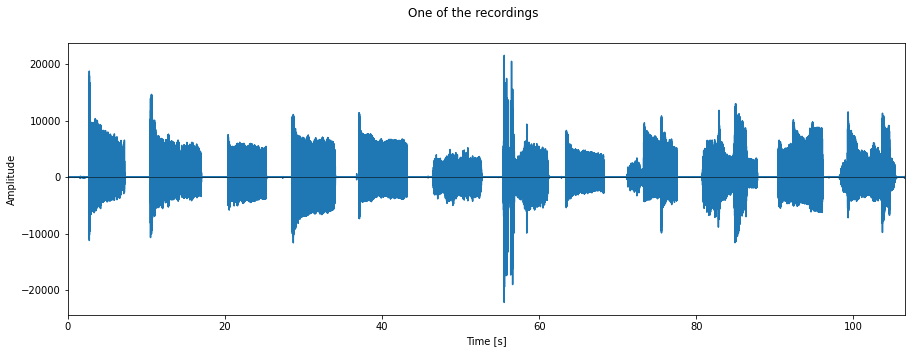

In [12]:
# Mostramos uno de los audios
plot_audios([recordings[0]], sampling_rate, title='One of the recordings')

In [23]:
# Podemos escucharlos, pero no enteros si son muy largos
gc.collect()
t_begin = 80  # s
t_end = 90  # s
Audio(recordings[0][t_begin * sampling_rate: t_end * sampling_rate], rate=sampling_rate)

<source src="data:audio/wav;base64,UklGRnR1DQBXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YVB1DQDi/+L/5f/n/+L/8f/q/+f/7//l//H/6v/0//H/4v/q/+L/5//n/+X/5f/n/+L/6v/q/+L/6v/q/+//6v/x/+r/6v/q/+z/9P/l/+//7//5//n/9P/5//b/+//5//b/9P/+//n//v8CAPH/9v/5/+//7//+//n/+f8AAPn/9P/7//7/+f/7//b/AAD5//T//v/0//n//v/5//b/9P/q/+z/6v/g/+L/5//q/+r/9P/q/+f/7P/g/+L/4v/l/9j/4P/l/9P/3f/W/9j/4P/Y/9b/zv/T/87/0f/R/8b/0f/G/8T/0//G/8H/yf/R/87/zv/T/8H/wf/J/8n/zP/J/8z/zP/R/9P/yf/M/8z/zP/T/9H/0f/J/8n/0f/O/9b/zv/T/9j/yf/W/9P/zv/W/9j/2P/g/+L/3f/n/+r/7P/v/+//8f/s//b//v/5//v/AgAAAPn/+f8FAAAAAgAHAPn/BQD7//b/BQD7//v//v/5//v/BQD5//b/AgAAAPH//v8AAPv/AgD+/wIA+//+//v//v/+/+r/AgD2//T/9v/x//b/7//0//T/9v/s/wAA+//2//7/6v/7//v/AAD7//v//v/5/wUAAgAAAPn/AgACAAAABQD0//n/9v8AAPv/8f/7/wAAAAAKAAwABQAHAA8ACgARABYADwAWABkAIAAbABsAGwAWACAAHgAlACUAJQAqACMAJQAgACUAIwAWABsAGwAjAB4AGQAtAB4AHgAqACAAJQAeACUALQAqACMAJQAoACMAIwAeACAAGQAWABYAFAAUAA8AFgAPABYAEQAPABEABwAMAAwACgD+/wUACgD+/wIA/v/2//T/9P/5//T/8f/v/+z/7//s/+f/7//v/+X/6v/n/+X/5//l/+f/4v/i/+z/8f/l/+r/7P/i//T/7P/s/+r/7//q/+r/9P/q//H/7//0//H/8f/2//b/AAAAAP7/+/8MAAAA+/8PAAIABwAPAAwAFAAPAA8AFAAUABYAEQAPAA8ADwARAAwAGQAeABYAFgAlACUAHgAtACMAJQAtACMALwAqACoAMgAqADQAMgA0ADoANwA8ADwANwA/AD8APAA8ADQANAAvADIALwAtADcAJQAlAB4AGwAjACMAGwAZAB4ADAAWAAwAAgAPAAIABwACAAAABQD7/wAAAgD2//b/+//2/+//8f/v/+r/7//v/+//8f/q/+r/8f/q//b/7P/g/+z/1v/l/+r/4v/g/+L/5f/g/+//4v/q/+r/8f/s/+r/9P/n//T/7P/0/+r/9P/+/+r//v/x//v//v/0/wIABwAAAAIABwD7//7/DAAKAPv/EQAMAAIAFgAWAA8ABwAUAAwACgAHAAwADAAFABEABQAPAAoABwAKAAoADAAMAAwAAAAKAAwAAgAFAAIAAAD+//7/9P/x//b/8f/0/+z/7//0/+//8f/q/+f/7P/n/+f/5f/i/+D/5f/i/9v/3f/W/9j/4P/Y/9j/4v/b/9v/3f/W/9j/zv/M/9j/0f/T/9j/2P/b/9H/3f/i/9j/3f/d/+X/4v/n/+X/4v/q/+X/8f/q/+r/9P/q/+//8f/0//H/9v/7//b/AAD+/wUA/v/+/wcADAAMAAoAHgARABkAJQAjACgAIwAlAC0ALQAoAC0AMgAvAC0ALwA3ADQANAA0ADcANAA3ADIAOgA3AC0ALQAlAC0AMgA3ACoALwAvAC0AKgAoACoAHgAoABQAFgAbAA8AEQAMAAwA/v8MAAAAAgACAPb/AAD5/wUAAgD7/wIAAAD5/wUABQD5/wAA+//+//v/AgD7//b/+//5//v/+/8AAPv/+//+/wIA+/8CAPv/9P8MAAAABwARAAUACgAMAA8ADAAMAA8ADwARABYAEQAeACAAGQAoACUAGwAbACUAIwAoADIAKgAvACgAKAA8ADQANwA/ADQANAA0ADwAPwA6ADwANwA/ADwAOgBEAEQAPwA6ADwAPwA8ADcAOgA3ACMALQAtACMAJQAeABsAHgAWABQAFAAMAAUABwAUAAAA/v8AAPT/AAD+//7/+f/0//n//v/2/+z/7//s/+r/5//q/+X/4v/n/93/4v/n/+L/4v/q/+r/6v/q/93/4v/q/+X/3f/g/+X/4P/g/+r/4v/l/93/4P/n/9b/5//l/+f/6v/q//v/8f/x//T//v/v//v/BQD0/woAAgACAAUACgAPAAoAEQAKABkAGQAWABsAFgAeABYAIwAoAB4ALQAoACoAKgAlACoAGwAlACUAGwAjABYAHgAlABYAFgAZABsAEQAUAB4ADAAPABEADwAKAAUACgD+/wcABQD+/wIA+//2/+//7//v/+f/4v/l/+L/4v/i/9b/4v/Y/9j/5f/R/9j/3f/O/9b/0//W/9P/zv/R/8b/xv/J/8n/xv/M/8T/uv/J/8T/xP/G/8T/xv/B/8T/xv/G/8T/yf/G/8z/zv/M/87/yf/M/87/xP/M/8z/yf/W/9j/2//b/+D/5f/d/+f/6v/n/+f/4v/n/+//7P/s/+//7P/v/+///v/7//n/AAD7/wUAAAD2/wAA/v8CAAUAAAAFAAIAAgACAAAAAAD+/wIAAgACAAAA+f/+//n/+//2//b/+//v/+//9v/x/+r/7//v/+L/6v/b/93/3f/d/+f/0f/i/9v/4P/n/9v/6v/d/+D/4P/b/9j/1v/d/9P/2//b/9j/0f/M/9j/0//W/87/0f/Y/9v/1v/O/+L/1v/W/9v/0f/b/9P/2P/g/+L/2//i/+r/3f/g/+D/5//i/+r/7P/x//v/8f/7//n/+f8AAPn/AAD+/wIAAgAAAAcABQAFAAoACgAMAAoAFgAbABEAFgAUABkAJQAZABkAIAAbACAAKAAlABYAGwAeABEAIwAZABQAIAAeAB4AIAAlABsAIAAbABsAIAAZAB4AGwAWABkAGwAMABQADwAMABEADAAMAP7/EQAFAAIABwD7/wUA/v8FAP7/AgACAP7/DwD+/wcAAgD7/wcA/v8KAAIAAAACAPv/AgD5//v/AgD5//b/8f/5//v/+//+//7/+f/2//n/9v/2//b/+//5/wAACgAAAAUAAgD+/wUABwAFAAAABQAPAAoABwAMAAcABwAMAA8AEQAKAAwAHgARAA8AGwAWABsAEQAbACMAFAAZAB4AGQARACAAFgAMABYADwARABQAFgAWABEAFAARAA8AGQAgABYAGwAWABQAIAAbABQAGQAZACAAIwAgACgAIAAlACoAIwAgABsAGwAbACAAHgAZABsAHgAoABYAFAAlABYAEQAgACUAHgAgAB4AGQAWABQAGwAWABkAFgAPABQABwAPABEABQAKABEADAAMABkACgAHAAoAAgAKAAoABQAMABQACgAPABQADAACAA8AGwAKABYADAAUABYAAAAbAAAAAAAUAAwAEQAMAAoAAAAUABEADwAWAAoAGQAUAAwAFAARABEAFgAZABEADAAPABYAGwAZABkAEQAKAA8ABQAMAAoA/v8CAPb/AADx//H/+f/v//n/7//x//v/7//x//b/7P/v//b/7//s//T/6v/n/+//5f/i/9v/5//n/+D/4v/W/9j/2P/d/9v/2P/W/9j/4P/Y/+f/1v/T/+D/0//Y/93/2//d/9j/0f/d/+D/0f/R/93/0//W/9j/1v/Y/9P/3f/l/+f/5//s/+r/6v/v//T/7P/s//b/+/8AAPT/BwACAP7/DAAHAA8ABQAPAA8AFgAPAAoAFAAHABkAEQAMAAoACgAKAAwADAAFAAUABQARAAUACgAHAAIAAgAHAAwABQAFAPn/BQACAAIABQD+/wcA/v/+/wUAAAD5/wUA9P/5/wAA6v/2//H/9v/+/+//9P/x/+f/5//n/+r/7P/s/+f/9P/v/

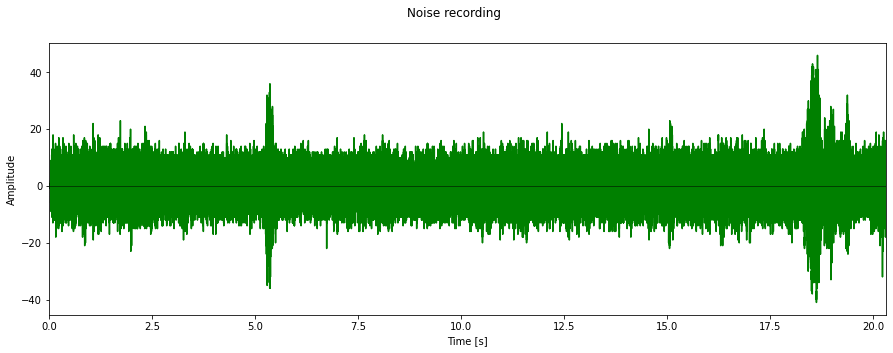

In [56]:
# Mostramos el registro del ruido
plot_audios([noise_recording], sampling_rate, title='Noise recording', colors=['g'])

### Filtro de Preacondicionamiento

Previo a la implementación de un filtro óptimo se realiza el filtrado convencional de las señales de audio, incluyendo el registro del ruido. Esto mejora el desempeño de toda la fase de acondicionamiento de las grabaciones, dado que elimina las frecuencias que no son de interés para el análisis posterior. La principal desventaja de utilizar un filtro de preacondicionamiento es la eliminación de armónicos de orden superior. No obstante, la contribución en potencia de estos armónicos es poco significativa y no modifica la percepción de la señal reproducida ante el oído humano.

Si bien el rango frecuencial del armónico fundamental para hombres oscila aproximadamente entre 85 y 180 Hz [1], se observó tras analizar las *Power Spectral Densities* (PSBs) que la mayor parte de la potencia de las señales se encuentra entre 50 y 14000 Hz (aunque sólamente los segmentos de las Fs y las Cs se ven afectados al fijar la frecuencia de corte superior en 1500Hz). Para poder realizar un primer análisis, se utilizaron las frecuencias definidas en el ámbito de la telefonía, probando las configuraciones *narrowband*, *wideband*, *superwideband* y *fullband*. Tras trabajar con un filtro pasabanda *superwideband* no se observó distorsión en la señal, por lo que implementamos esta configuración.

Por otro lado, en cuanto al tipo de filtro, se intentó implementar filtros FIR simétricos, debido a que poseen un mejor desempeño en fase. No obstante, dados los requisitos impuestos sobre las especificaciones de atenuación y los anchos de ventana, el orden del filtro resulta computacionalmente impráctico y se decidió ir por un filtro IIR. La fase alineal de estos filtros no resulta un problema en este caso, ya que al implementar los filtros de forma *offline* es posible cancelar la fase del filtro al aplicarlo de derecho y de revés con la función *(sos)filtfilt* de *scipy.signal*. 

Por último, en todos los casos se removió el ruido de línea de 50 Hz, que se reconoce al graficar la PSD del registro del ruido ambiental. (Ver más adelante)

In [5]:
# Algunas consideraciones:

alpha_s = 45  # atenuación en dB de la banda de rechazo
DeltaF = 2  # Ancho de la ventana
narrowband_frequencies = [300, 3400]  # Pasabandas
wideband_frequencies = [50, 7000]  # Pasabandas
superwideband_frequencies = [50, 14000]  # Pasabandas
fullband_frequencies = [20, 20000]  # Pasabandas
line_frequency = 50  # Notch

In [14]:
# Caso: FIR (descartado)

# Obtengo el orden del filtro
beta_kaiser = sig.kaiser_beta(alpha_s)
DeltaOmega = 2 * np.pi * DeltaF / sampling_rate
Lh = np.ceil(1 + (alpha_s - 8) / (2.285 * DeltaOmega))  # cálculo del orden del filtro
Lh = int(Lh * 1.05)  # factor de seguridad correctivo
assert Lh / sampling_rate < 1.5, 'Aumente el rango frecuencial'  # toleramos una demora máxima de 1.5 segundos

window = ('kaiser', beta_kaiser)  # Ventana utilizada

narrowband_coefficients_fir = sig.firwin(Lh, [narrowband_frequencies[0] - DeltaF / 2,
                                              narrowband_frequencies[1] + DeltaF / 2],
                                         pass_zero='bandpass', fs=sampling_rate, window=window)
windeband_coefficients_fir = sig.firwin(Lh, [wideband_frequencies[0] - DeltaF / 2,
                                             wideband_frequencies[1] + DeltaF / 2],
                                        pass_zero='bandpass', fs=sampling_rate, window=window)
superwideband_coefficients_fir = sig.firwin(Lh, [superwideband_frequencies[0] - DeltaF / 2,
                                                 superwideband_frequencies[1] + DeltaF / 2],
                                            pass_zero='bandpass', fs=sampling_rate, window=window)
fullband_coefficients_fir = sig.firwin(Lh, [fullband_frequencies[0] - DeltaF / 2,
                                            fullband_frequencies[1] + DeltaF / 2], pass_zero='bandpass',
                                       fs=sampling_rate, window=window)

Lh_line_supressor = Lh if Lh % 2 else Lh + 1
line_supressor_coefficients_fir = sig.firwin(Lh_line_supressor,
                                             [line_frequency - DeltaF / 2, line_frequency + DeltaF / 2],
                                             pass_zero='bandstop', fs=sampling_rate, window=window)

In [21]:
# Caso: IIR
# El uso de la configuración SOS (Successive Cascade Sequences) evita errores del tipo numéricos

narrowband_sos_iir = sig.iirdesign([narrowband_frequencies[0], narrowband_frequencies[1]],
                                   [narrowband_frequencies[0] - DeltaF, narrowband_frequencies[1] + DeltaF],
                                   .2, alpha_s, fs=sampling_rate, output='sos')
wideband_sos_iir = sig.iirdesign([wideband_frequencies[0], wideband_frequencies[1]],
                                 [wideband_frequencies[0] - DeltaF, wideband_frequencies[1] + DeltaF],
                                 .2, alpha_s, fs=sampling_rate, output='sos')
superwideband_sos_iir = sig.iirdesign([superwideband_frequencies[0], superwideband_frequencies[1]],
                                      [superwideband_frequencies[0] - DeltaF,
                                       superwideband_frequencies[1] + DeltaF],
                                      .2, alpha_s, fs=sampling_rate, output='sos')
fullband_sos_iir = sig.iirdesign([fullband_frequencies[0], fullband_frequencies[1]],
                                 [fullband_frequencies[0] - DeltaF, fullband_frequencies[1] + DeltaF],
                                 .2, alpha_s, fs=sampling_rate, output='sos')
line_supressor_sos_iir = sig.iirdesign([line_frequency - DeltaF, line_frequency + DeltaF],
                                       [line_frequency - DeltaF / 2, line_frequency + DeltaF / 2],
                                       .2, alpha_s, fs=sampling_rate, output='sos')

In [16]:
# Respuesta en frecuencia de los filtros:

def plot_freq_response_dlti(filter_parameters, sampling_frecuency, input_type='ba',
                            plot_phase=False, zoom_area=None, title=None):
    sampling_time = 1 / sampling_frecuency
    if zoom_area:
        array_omega = 2 * np.pi * sampling_time * np.linspace(zoom_area[0], zoom_area[1], 10000)
    else:
        array_omega = None
    if input_type == 'sos':
        array_discrete_freq, freq_response = sig.sosfreqz(filter_parameters, worN=array_omega)
    elif input_type == 'ba' or input_type == 'zpk':
        sys_sig = sig.dlti(*filter_parameters)
        array_discrete_freq, freq_response = sys_sig.freqresp(array_omega)
    else:
        raise ValueError('imput_type must be "ba", "sos" or "zpk"')

    gc.collect()  # avoiding memory leaks
    if plot_phase:
        fig_filter_response, ax_filter_response = plt.subplots(2, 1, figsize=(10, 10))
        ax_filter_response[0].plot(array_discrete_freq / (2 * np.pi * sampling_time),
                                   20 * np.log10(np.abs(freq_response)))
        ax_filter_response[0].set_ylabel("dB")
        ax_filter_response[0].set_xlabel("f", loc='right')
        ax_filter_response[0].grid()
        ax_filter_response[1].plot(array_discrete_freq / (2 * np.pi * sampling_time), np.angle(freq_response))
        ax_filter_response[1].set_ylabel(r"$\angle H(e^{j\Omega})$")
        ax_filter_response[1].set_yticks([-np.pi + i * np.pi / 4 for i in range(9)],
                                         ['$-\pi$', '$-\\frac{3}{4}\pi$', '$-\\frac{1}{2}\pi$',
                                          '$-\\frac{1}{4}\pi$', '$0$', '$\\frac{1}{4}\pi$',
                                          '$\\frac{1}{2}\pi$', '$\\frac{3}{4}\pi$', '$\pi$'])
        ax_filter_response[1].set_xlabel("f [Hz]", loc='right')
        ax_filter_response[1].grid()
    else:
        fig_filter_response, ax_filter_response = plt.subplots(1, 1, figsize=(10, 10))
        ax_filter_response.plot(array_discrete_freq / (2 * np.pi * sampling_time), 20 * np.log10(np.abs(freq_response)))
        ax_filter_response.set_ylabel("dB")
        ax_filter_response.set_xlabel("f [Hz]")
        ax_filter_response.grid()
    if title is not None:
        ax_filter_response.set_title(title)
    fig_filter_response.tight_layout()
    fig_filter_response.show()

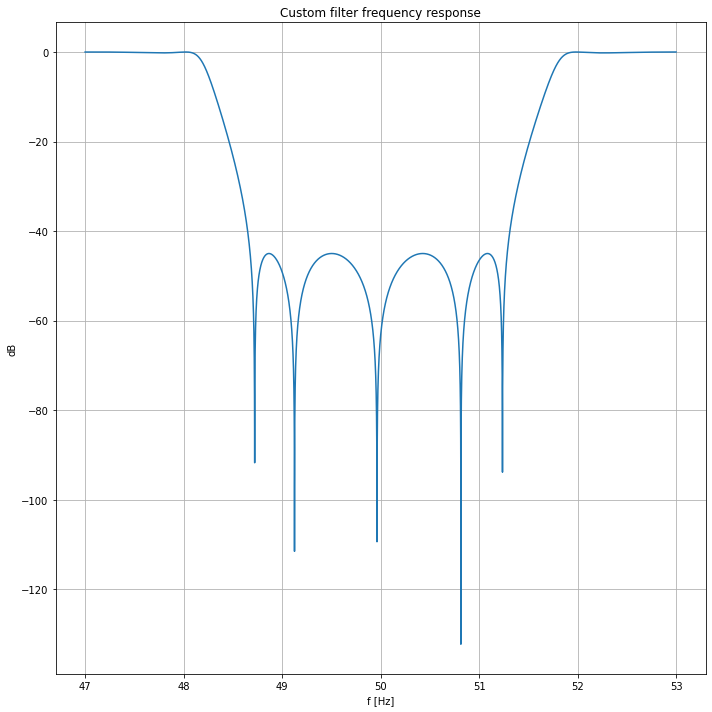

In [147]:
# Evaluamos la respuesta del filtro que querramos analizar
plot_freq_response_dlti(line_supressor_sos_iir, sampling_rate, input_type='sos', zoom_area=[47, 53],
                        title='Custom filter frequency response')

In [22]:
# Probamos los resultados de la configuración elegida
recording = recordings[11]
filtered_recording = sig.sosfiltfilt(superwideband_sos_iir, recording)
filtered_recording = sig.sosfiltfilt(line_supressor_sos_iir, filtered_recording)

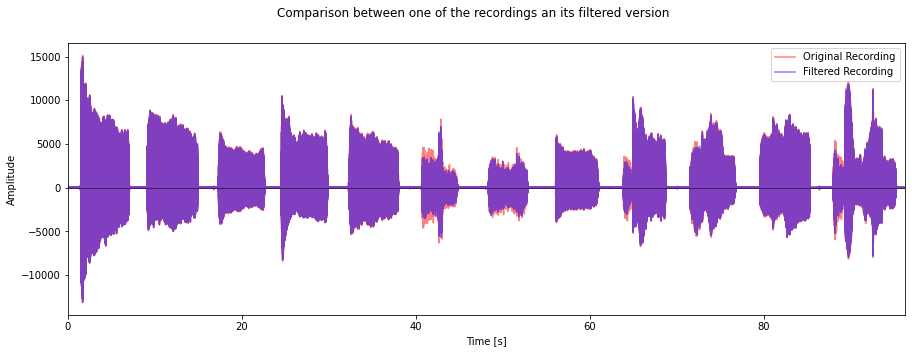

In [23]:
# Mostramos el resultado
plot_audios([recording, filtered_recording], sampling_rate, labels=['Original Recording', 'Filtered Recording'],
            colors=['r', 'b'], title='Comparison between one of the recordings an its filtered version', opacity=0.5)

In [209]:
gc.collect()
t_begin = 40  # s
t_end = 57  # s
Audio(filtered_recording[t_begin * sampling_rate: t_end * sampling_rate], rate=sampling_rate) 

<source src="data:audio/wav;base64,UklGRizhFgBXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YQjhFgDp/+H/4v/j/+D/6f/0/+7/5//t/+3/4v/l/+3/8f/2//D/4P/g/+b/3f/Z/+H/3v/b/+b/4v/W/97/4f/R/9X/5f/a/9L/3v/c/8z/0P/b/9D/wv/E/8r/xf+7/7b/s/+r/6b/q/+w/7D/s/+6/8D/wP+3/7b/yP/T/8r/y//U/8n/wf/J/8P/u//J/9H/w//I/9n/zf+9/8b/zv/J/87/3//m/97/1//g/+v/7f/x//j/9v/1/wEABQD8//r//P/4//z/AgADAAkAEAAFAPv/AAAIAAkADQARABUAHQAfAB0AIwAjABkAFgAYAA4ABAAGABAAGAAQAAIAAgAGAPr/7//y/+z/4v/o/+z/6v/w//T/6P/k/+//+P/+/////P//////9f/y//T/8v/x//D/4f/h//P/7P/a/+n//P/4//r/AgAAAAkAEAD+//v/DwAIAPj/DQAaAAYACAAfACMAJQApABoAEwAgAB0AFQAgACUAGwAiADIAMAArAC8AMwA5AEEARgBIAEYAQAA5ADEALAAuADMANQA/AEgARQA+AEAAQAA/AD8APQBBAEkAQgA0ADQANQAvAC8AMQAwADQAMgAiACEAKQAcABEAIQAxADIAMAAlABoAIgAlABUAEgAgACcALwA2ACsAIAAoACwAJQAiACUAJQAjACEAIAAdABcAHwAsACMAFQAeACkAJwApACIADAAOABwAEwANABcACwD5/wIAEAALAAwADwAIAAgADAACAAIAEAARAAgABgAGAAUACQATACMAJQAUABIAIwAcAAgAEgAhAB8AJwAyACcAIgAxADUAMgA0AC8ALwBCAEoAPQA2ADUANAA9AEsASwBHAEgAUABWAE0AQQBKAFcATwBJAFMAVwBXAF0AWQBVAGAAZwBlAGwAbQBgAFwAXwBfAGIAXQBPAFYAZwBjAF8AaQBoAGMAawBpAGEAZABdAEwATwBOADoANAA2ACgAIgAoAB8AHQAwAC0AHQAiAB8ADgAWACIAFQAVACkAKwAlACsAKAAaABYAFgAUAA8AAwD9//7/9P/l/+n/6f/b/9n/4P/a/9L/1v/Y/9j/2//c/+L/5//k/+f/8P/o/93/5f/p/+P/6v/q/9T/yf/P/8r/wP/E/8f/x//K/8r/yP/L/8//1P/a/9n/3f/q/+3/5v/o/+P/0//W/+H/1v/L/83/xv+//8f/xv+3/7f/w//E/7//vP+6/7j/uv/E/9D/zP/F/9P/4//a/87/0P/O/8v/1f/V/8L/u//C/8T/x//L/7//sf+0/7v/uP+8/8n/y//H/9H/3v/X/8z/1P/g/+D/4f/j/9j/zv/W/9r/zv/F/8v/2f/i/9z/z//K/8n/xv/N/9j/2v/e/+f/5P/e/+X/6P/d/97/7f/x/+7/9f/+//j/6f/n/+7/8P/v//b/+v/2//X/+f///wUABAD//woAHAAWAAcACAAPABIAGgAYAAsADAASAAYA+f/9/wQAAwAGAA8AEwALAP7/9f/5/wEABAD+//X/9/////z/9v/y/+j/4f/q//X/8//w/+n/3//j/+X/0//M/9v/1P/E/8v/yv+u/6T/qP+b/5v/s/+0/6P/qP+0/7T/uP+8/7f/uf/E/8P/uP+z/7T/uP+9/77/uv+5/77/yP/Q/9T/0f/E/7n/v//N/9D/1P/e/97/2v/m/+7/5P/k//j/AgAAAAMACwAHAAAA/f/+////BgAPAA4ADAATABAAAAD8/wwAGQAcAB0AFwAVACUAKwAfACMANwA+ADkAOgA5ADUANAAzADEAMwA4ADwAOgA0ADIAMQAmAB4AIgAjACAAJAAoACkANQA4ACMAGAAgABwAEgAbACQAJAAiABkAEAAYACAAGgAZABgACgAAAAAA/P8AAAwACAAAAAcACAD+////AAD6/wAADgANAAYABwALABEAEwANAA0ADQAFAAoAFwAOAAAABQAIAAoAGwAiABYAHAAqAB8AHAAsACcAEgAXACQAIgAhACIAHgAcAB8AHQAWABAAFQAhACIAHAAmADcAMQApADQAOgAxADAAOwA6ADAALAAwAC0AKQAuADIAKAAgACEAFgAKABUAHQANAAUADAAIAAEABgAFAP3//f/7//P/+P////z/+//7//L/7//1//H/5//p/+//6f/i/+T/6v/o/+T/7f/y/+P/1P/a/+D/4P/p/+v/4v/m//P/7//m/+P/3P/X/+P/5//W/8//2//j/97/0//E/7r/wf/O/83/xv/J/8z/yf/M/9H/yv/K/9z/5v/l//L/9//l/+H/7//0//L/8P/e/9D/2P/Z/9H/3f/p/9//2v/h/97/3v/q//T//P8IAAsABwAEAP//AwAUABIACAATABkADAAMAA8ABQAHAA0A///5/woABADu//H/9//w//j/AgD9/wAACAAAAP3/DAAPAAMABAAHAP7/+v/+/wAA/f/2//P/9f/y/+7/8v/2//L/7v/p/+P/7P/y/+j/4v/p/+r/5v/p/+n/6v/2//j/6v/m/+z/6//n/9//2v/g/+j/4//b/9n/3P/h/97/zv/I/9L/0//Q/9P/0P/N/9v/5//k/+X/5//i/+H/3v/P/8//4v/k/97/4v/f/9f/3//o/+H/3//q/+7/7f/w/+//5//l/+v/7//u/+3/6v/h/9//7v/1/+j/4f/m/+j/7f/2/+//6f/1//P/4//t//7/8P/p//3/AADy//L/9v/w//H/9//w/+b/5//q/+X/4v/t//f/7v/i/+X/6//p/+j/5//m//H/+f/x/+//9//t/+H/7//4/+z/6P/x//H/7//v/+j/4f/n//T/9//r/+P/8P/7//X/+P8HAAUA/v8HAA8ACgAMAA8ABwAGAAwACQAFAAwAFQAXABcAGgAhAB0AFAAZACIAGwAWAB0AGAAUACEAJwAhACcALgAqADIAOgAsACYAMgAzADAANQAsACEALQA0ACoALAAzAC8AOwBMAEcARgBWAFMARQBMAFMASABKAFgAVwBMAEQAPQA7AD4AOgAwAC0ALwAvAC4ALQAoACIAJwAzADQALgA1AD4APgA/AD8AOQA9AEcAQAA4AD4ANwApAC8AMwAkACIAJwAhACkAPAA2ACsAOAA8ADIAOQBGAEYARABEAEcATwBLADkAOABIAEsATABRAEkAPwBKAFIASwBHAEsASwBIAEoATwBMADkAMABAAEUANgAyADcALwAxAD4ANQAoADYASgBKAEIAPAA2ADMAMgA3ADsALwAjACgAJAAOAA8AHgAaABMAGAAOAPv/+P///wIACgAPAAwADgAQABEAEAAKAAcAFgAbAAsACQARAAoABAAJAAAA+/8HAAQA9P/6/wYAAQADAA0ACwAHAAsADQAPAAsA/////w8AFwAWABcAEgASAB8AGgAIAAgACgD/////DAAJAP////8AAP3/9v/y//f//v/9/wAABwAGAAIACQARABIAEAAIAAMACgAKAAUADQAOAAAAAAAHAPr/9P/9//P/5v/r/+f/3f/q//L/6//1//z/7v/u//7/+P/x//f/6v/c/+n/8v/r/+n/5f/d/+P/7f/r/+f/4v/e/+3/9//p/+H/6P/k/+H/6f/j/9f/2v/a/9X/3P/Z/8r/0v/f/9X/0//l/+b/3P/f/9//1//e/+//+P/8//r/9v/3//j/9f/x//D/7v/n/9//4//w/+z/3v/h/+f/4//o/+3/4f/a/+L/4//h/+r/7f/o/+//9P/y//n/+//s/+j/9P/0/+z/7f/q/+L/4P/g/+H/3//U/9D/2f/X/9P/4f/r/+X/6v/2/+3/4v/p//T/+v/9//n/8//0//D/6P/h/9f/0P/U/9H/yv/N/8z/wP/A/8b/w//H/9T/0//R/9z/5P/m/

In [24]:
# Creamos el filtro de preacondicionamiento:
def preconditioning_filter(audio_recording: NDArray[(Any,), Real]) -> np.ndarray:
    """
    This function implements the desired configuration for the preconditioning filter.
    INPUT:
        audio_recording (np.ndarray): array containing the recording to be filtered.
    OUTPUT:
        filtered_recording (np.ndarray): array containing the filtered recording.
    """
    return sig.sosfiltfilt(line_supressor_sos_iir, sig.sosfiltfilt(superwideband_sos_iir, audio_recording))

In [25]:
# Lo aplicamos
preaconditioned_recordings = [preconditioning_filter(recording) for recording in recordings]

## Aplicación de un filtro óptimo

Utilizamos un filtro adaptativo en configuración *Adaptive Noise Cancelation* (ANC)

In [26]:
def extend_array_own(original_array: NDArray[(Any,), Real], desired_length: int,
                     remembering_index: None | int = None) -> NDArray[(Any,), Real]:
    """
    This function extend an array using is own data, in such way that the extended segment couples as smoothly as possible
    with the original array. This avoids the introduction of high frecuency components. It can extend an array in more than
    the double of its original length in an efficient way.
    """

    original_length = len(original_array)
    assert original_length < desired_length, 'The desired length must be greather than the original one'
    original_array = np.array(original_array)
    extended_array = original_array[:]
    if remembering_index is None:
        differential = [(index, np.abs(element - extended_array[-1])) for index, element in
                        enumerate(extended_array[:original_length // 2])]
        differential.sort(key=lambda element: element[1])
        remembering_index = differential[0][0]
        if desired_length <= 2 * original_length - remembering_index:
            return np.concatenate((extended_array,
                                   extended_array[
                                   remembering_index:remembering_index + desired_length - original_length]))
        else:
            extended_array = np.concatenate((extended_array, extended_array[remembering_index:]))
            differential = [(index, np.abs(element - extended_array[-1])) for index, element in
                            enumerate(extended_array[:original_length // 2])]
            differential.sort(key=lambda element: element[1])
            remembering_index = differential[0][0]
            return extend_array_own(extended_array, desired_length, remembering_index=remembering_index)
    else:
        if desired_length <= 2 * original_length - remembering_index:
            return np.concatenate((extended_array,
                                   extended_array[
                                   remembering_index:remembering_index + desired_length - original_length]))
        else:
            added_length = len(extended_array[remembering_index:])
            extended_array = np.concatenate((extended_array, extended_array[remembering_index:]))
            return extend_array_own(extended_array, desired_length, remembering_index=remembering_index + added_length)


def adaptative_filter(signal: NDArray[(Any,), Real], desired_signal: NDArray[(Any,), Real], filter_length: int,
                      convergence_a: None | Real = None) \
        -> Tuple[NDArray[(Any,), Real], NDArray[(Any,), Real], Tuple[NDArray[(Any,), Real], NDArray[(1,), Real]]]:
    """
    Implements LMS (least mean squares) to find the adaptative filter coefficient for a given signal, desired signal,
    given filter length and a convergence speed parameter.
    """
    if convergence_a is None:
        convergence_a = 0.5
    convergence_mu = convergence_a / (10 * np.mean(signal ** 2) * filter_length)

    signal_length = len(signal)
    signal = np.reshape(signal, (signal_length, 1))
    desired_signal = np.reshape(desired_signal, (signal_length, 1))
    adaptative_coefficients = np.zeros((filter_length, 1))
    filtered_signal = np.zeros((signal_length, 1))
    error = np.zeros((signal_length, 1))
    for index in range(filter_length):
        error[index] = desired_signal[index]
    for index in range(filter_length, signal_length):
        signal_reversed = signal[index:index - filter_length:-1]
        filtered_signal[index] = adaptative_coefficients.T.dot(signal_reversed)
        error[index] = desired_signal[index] - filtered_signal[index]
        adaptative_coefficients += convergence_mu * error[index] * signal_reversed
    adaptative_coefficients_end = (adaptative_coefficients.ravel(), np.array([1]))
    return filtered_signal.ravel(), error.ravel(), adaptative_coefficients_end


def raw_correlation(x: NDArray[(Any,), Real], y: NDArray[(Any,), Real], max_lags=None) -> NDArray[(Any,), Real]:
    """
    Returns the raw correlation of two signals accordings to Matlab's documentation, up to max_lags if specified.
    It has the advantage that it does not calculate the correlation at every lag if max_lags is given.
    """
    x = np.array(x)
    y = np.array(y)
    if max_lags is None:
        max_lags = max(len(x), len(y)) - 1
    correlation = np.zeros((2 * max_lags + 1,))
    for corr_index in range(len(correlation)):
        lag = corr_index - max_lags
        x_start = 0 if lag < 0 else lag
        y_start = -lag if lag < 0 else 0
        if len(x) > len(y):
            x_end = len(y) + lag if lag < 0 else min(lag + len(y), len(x))
            y_end = len(y) if lag < 0 or lag + len(y) <= len(x) else len(y) - (lag + len(y) - len(x))
            if y_start < len(y):
                correlation[corr_index] = np.sum(x[x_start:x_end] * y[y_start:y_end])
            else:
                correlation[corr_index] = 0
        else:
            x_end = min(len(y) + lag, len(x)) if lag < 0 else len(x)
            y_end = y_start + min(len(y) + lag, len(x)) if lag < 0 else y_start + len(x) - lag
            if x_start < len(x):
                correlation[corr_index] = np.sum(x[x_start:x_end] * y[y_start:y_end])
            else:
                correlation[corr_index] = 0
    return np.array(correlation)


def raw_correlation_function(x: NDArray[(Any,), Real], y: NDArray[(Any,), Real], lag: int = 0) -> Real:
    """
    It calculates the cross correlations of signals x and y, at a given lag.
    """
    x = np.array(x)
    y = np.array(y)
    x_start = 0 if lag < 0 else lag
    y_start = -lag if lag < 0 else 0
    if len(x) > len(y):
        x_end = len(y) + lag if lag < 0 else min(lag + len(y), len(x))
        y_end = len(y) if lag < 0 or lag + len(y) <= len(x) else len(y) - (lag + len(y) - len(x))
        if y_start < len(y):
            correlation = np.sum(x[x_start:x_end] * y[y_start:y_end])
        else:
            correlation = 0
    else:
        x_end = min(len(y) + lag, len(x)) if lag < 0 else len(x)
        y_end = y_start + min(len(y) + lag, len(x)) if lag < 0 else y_start + len(x) - lag
        if x_start < len(x):
            correlation = np.sum(x[x_start:x_end] * y[y_start:y_end])
        else:
            correlation = 0
    return correlation


def wiener_hopf_filter(signal: NDArray[(Any,), Real], desired_signal: NDArray[(Any,), Real], filter_order: int) \
        -> Tuple[NDArray[(Any,), Real], NDArray[(1,), Real]]:
    """
    This function finds the Wiener-Hopf filter coefficients for an optimal filter. It takes a signal, a desired system output and
    a filter order. The returned coefficients are in the form b, a (num, den). Note that a = [1] always (MA model).
    """
    rxx = [raw_correlation_function(signal, signal, lag) for lag in range(0, filter_order + 1)]
    rdd0 = raw_correlation_function(desired_signal, desired_signal)
    rxd = [raw_correlation_function(signal, desired_signal, lag) for lag in range(0, filter_order + 1)]
    assert np.linalg.cond(toeplitz(rxx)) < 50000, 'The toeplitz matrix is ill conditioned'
    filter_coefficients = (solve_toeplitz(rxx, rxd) * (rxx[0] / rdd0) ** .5, np.array([1]))
    return filter_coefficients

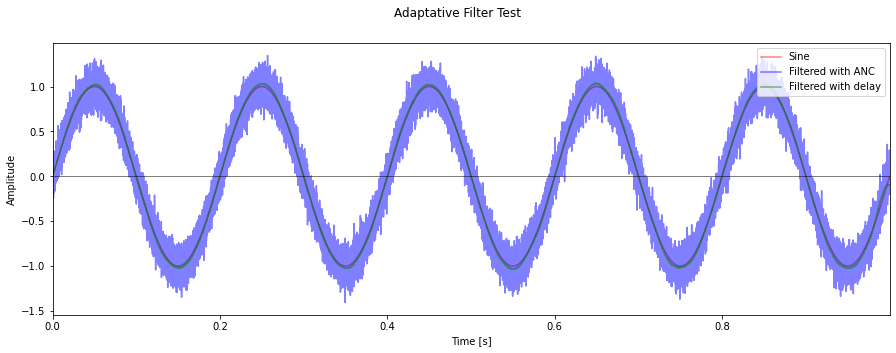

In [290]:
# Tests for the adaptative filter

time = np.arange(1 * sampling_rate) / sampling_rate  # Time array
sine = np.sin(2 * np.pi * 5 * time)  # Sine with F_sine = 5
SNP = 3
noise = np.random.randn(1 * sampling_rate) / SNP ** 2  # White Noise

_, _, afc_anc = adaptative_filter(sine + noise, noise, 2 ** 9, 0.9)  # Does not work
filtered_anc = sine + noise - sig.filtfilt(*afc_anc, sine + noise)
_, _, afc_delayed = adaptative_filter(sine + noise, np.roll(sine + noise, 5), 2 ** 10,
                                      0.9)  # Adaptative Line Enhancement, works
filtered_delayed = sig.filtfilt(*afc_delayed, sine + noise)

plot_audios([sine, filtered_anc, filtered_delayed], sampling_rate,
            ['Sine', 'Filtered with ANC', 'Filtered with delay'],
            title='Adaptative Filter Test', colors=['r', 'b', 'g'], opacity=0.5)

In [27]:
# Aplicación del filtro óptimo
filtered_recordings = []
for recording in preaconditioned_recordings:
    # Por razones de eficiencia computacional, el orden del filtro se fijó en 2^8
    # Por motivos de convergencia, se configuró el a_convergence del filtro en 0.4
    _, _, adaptative_filter_coeff = adaptative_filter(recording, np.roll(recording, 5), 2 ** 8, 0.4)
    filtered_recordings.append(sig.filtfilt(*adaptative_filter_coeff, recording).astype('int16'))
    print('Iteration done.')
clear_output()

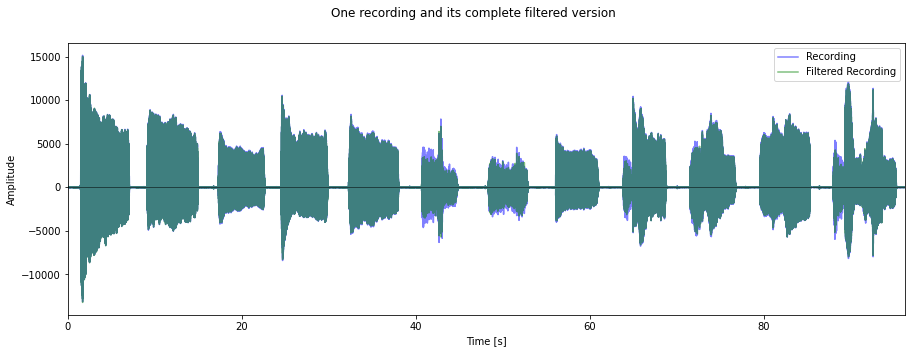

In [304]:
# Visualizamos uno de los resultados
recording_index = 11
plot_audios([recordings[recording_index], filtered_recordings[recording_index]], sampling_rate,
            labels=['Recording', 'Filtered Recording'], title='One recording and its complete filtered version',
            colors=['b', 'g'], opacity=0.5)

In [305]:
# Escuchamos el resultado
t_begin = 40  # s
t_end = 50  # s
Audio(filtered_recordings[recording_index][t_begin * sampling_rate: t_end * sampling_rate], rate=sampling_rate)

<source src="data:audio/wav;base64,UklGRnR1DQBXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YVB1DQDu/+T/5P/k/+T/6f/3//L/6f/u//L/5P/k//L/8v/3//L/5P/g/+n/4P/b/+T/4P/b/+n/5P/W/+D/5P/S/9b/6f/b/9L/5P/g/83/0v/g/9L/xP/I/83/yP+//7b/tv+x/6f/rP+2/7H/tv+//8T/xP+6/7r/yP/W/83/zf/W/83/xP/N/8j/uv/N/9b/xP/I/9v/zf+//8j/0v/N/9L/4P/p/+D/2//g/+7/8v/y//z//P/3/wAABAD8//z/AAD8//z/AAAAAAQADgAEAPz/AAAJAAQACQAOABIAHAAcABwAIAAgABcAEgAXAA4AAAAEAA4AEgAOAAAAAAAEAPz/7v/y/+7/5P/p/+7/6f/y//f/6f/k//L//P8AAAAAAAAAAAAA9//y//f/9//y//L/5P/k//L/7v/b/+n/AAD8//z/AAAAAAQADgAAAPz/DgAEAPf/CQAXAAQABAAcACAAJQAlABcAEgAgABwAEgAgACAAFwAgAC4ALgAqAC4ALgA4AEEAQQBGAEYAPAA4AC4AKgAqADMAMwA8AEYAQQA8ADwAQQA8ADwAPAA8AEYAQQAuADMAMwAqACoALgAuADMALgAgABwAKgAcAA4AIAAuAC4ALgAlABcAIAAlABIADgAgACUALgAzACoAHAAlACoAIAAgACUAIAAgACAAHAAcABcAHAAqACAAEgAcACoAJQAlACAACQAJABwAEgAJABcACQD8/wAADgAJAAkADgAEAAQACQAAAAAADgAOAAQABAAEAAAACQASACAAJQASAA4AIAAcAAQADgAgABwAJQAuACUAIAAuADMALgAzAC4AKgBBAEYAOAAzADMALgA8AEoARgBGAEYASgBUAEoAPABGAFQASgBGAE8AVABUAFkAWQBPAF0AZwBiAGsAawBdAFkAXQBdAF0AXQBKAFQAZwBiAFkAZwBnAGIAZwBnAF0AYgBZAEoASgBKADgALgAzACUAIAAlABwAHAAuACoAHAAgABwACQASACAAEgASACoAKgAlACoAJQAXABcAEgASAA4AAAD8/wAA9//k/+7/7v/b/9v/5P/b/9b/2//b/9v/4P/g/+T/6f/k/+n/8v/p/+D/6f/u/+T/7v/u/9b/zf/S/83/xP/I/8j/yP/N/83/yP/N/9L/1v/g/9v/4P/u/+7/6f/u/+n/1v/b/+T/1v/N/9L/yP+//83/yP+6/7r/xP/E/8T/v/+6/7r/v//E/9L/0v/E/9b/6f/b/9L/1v/S/83/2//W/8T/v//E/8T/zf/N/7//tv+6/7r/uv+//8j/zf/N/9L/4P/b/83/1v/k/+T/5P/p/9v/0v/b/+D/0v/I/83/2//k/+D/0v/N/83/yP/N/9v/2//g/+n/5P/g/+n/6f/g/+D/8v/y//L/9/8AAPz/7v/p//L/8v/u//f/AAD3//f//P8AAAQABAAAAAkAHAAXAAQABAAOAA4AFwAXAAkACQASAAQA/P8AAAAAAAAEAA4ADgAJAAAA9//8/wAAAAAAAPf/9/8AAAAA9//y/+7/5P/u//f/9//y/+7/4P/k/+n/1v/N/+D/1v/E/83/zf+x/6f/rP+e/57/tv+2/6f/rP+2/7b/uv+//7r/v//I/8T/uv+2/7b/uv+//7//uv+//7//yP/W/9b/0v/I/7r/v//S/9L/1v/g/+D/2//p//L/5P/k//z/AAAAAAQACQAEAAAAAAAAAAAABAAJAA4ACQAOAA4AAAD8/wkAFwAXABwAFwASACAAKgAcACAAOAA8ADMAOAA4ADMAMwAzAC4AMwA4ADgAOAAzAC4ALgAlABwAHAAgABwAIAAlACUAMwA4ACAAEgAgABwADgAXACAAIAAgABcADgAXACAAFwAXABcACQAAAAAAAAAAAAkABAAAAAQABAAAAAAAAAD8/wAADgAJAAQABAAJAA4AEgAJAAkADgAEAAQAEgAOAAAABAAEAAkAFwAgABIAHAAqABwAFwAqACUADgAXACAAIAAgACAAHAAcABwAFwASAA4AEgAgACAAFwAlADgALgAlADMAOAAuAC4AOAA4AC4AKgAqACoAKgAqAC4AJQAcACAAFwAJABIAHAAJAAQACQAEAAAABAAEAAAAAAD8//L//P8AAPz//P8AAPL/8v/3//L/6f/u//L/6f/k/+T/7v/p/+T/7v/3/+T/1v/b/+T/4P/p/+7/5P/p//f/8v/p/+n/4P/b/+n/6f/W/9L/4P/k/+D/1v/E/7//xP/N/83/yP/I/83/zf/N/9L/zf/N/+D/6f/p//L//P/p/+T/8v/3//L/8v/g/9L/2//b/9L/4P/u/+D/2//k/+D/4P/u//f//P8EAAkABAAEAAAAAAASABIABAASABcACQAJAA4ABAAEAA4AAAD8/wkAAADu//L//P/y//z/AAD8/wAACQAAAAAADgAOAAAABAAEAAAA/P8AAAAAAAD3//L/9//3/+7/8v/8//L/8v/u/+T/7v/3/+n/5P/u/+7/6f/u/+n/6f/3//z/6f/p/+7/7v/p/+T/2//g/+7/5P/b/9v/4P/k/+D/0v/I/9b/1v/S/9b/0v/N/+D/6f/k/+n/6f/k/+T/5P/S/9L/5P/k/+D/5P/g/9v/5P/p/+D/5P/u/+7/7v/y/+7/6f/p/+7/8v/y/+7/7v/k/+D/7v/3/+n/4P/p/+n/7v/3//L/6f/3//f/5P/u/wAA8v/p/wAAAADy//f/9//y//L/9//y/+n/6f/p/+n/5P/u//f/8v/k/+T/7v/p/+n/6f/p//L//P/y/+7//P/u/+T/8v/8/+7/6f/y//L/8v/y/+n/5P/p//f/9//u/+T/8v8AAPf/9/8EAAQAAAAEAA4ACQAJAA4ABAAEAA4ABAAAAA4AEgASABcAFwAcABwAEgAXACAAHAASABwAFwASACAAJQAcACUALgAqAC4AOAAqACAALgAuACoAMwAqABwAKgAzACUAKgAuACoAOABKAEEAQQBUAE8AQQBKAE8ARgBKAFQAVABKAEEAOAA4ADwAMwAuACoAKgAqAC4AKgAlACAAJQAuADMAKgAuADwAPAA8ADwAOAA4AEYAPAAzADwAOAAlACoAMwAgACAAJQAgACUAPAAzACoAOAA8AC4AOABGAEEAQQBBAEEASgBKADMAMwBGAEYASgBPAEYAPABKAE8ARgBGAEoARgBGAEYASgBKADgALgA8AEYAMwAuADgALgAuADwAMwAlADMASgBGAEEAOAAzADMALgAzADgALgAgACUAJQAOAAkAHAAXAA4AFwAOAPz//P8AAAAACQAOAAkADgAOAA4ADgAJAAQAEgAcAAkABAASAAkAAAAJAAAA/P8EAAQA9//8/wQAAAAAAA4ACQAEAAkACQAOAAkAAAAAAA4AFwASABcAEgAOABwAFwAEAAQACQAAAAAADgAEAAAAAAAAAPz//P/y//f/AAAAAAAABAAEAAAACQAOAA4ADgAJAAAACQAJAAAACQAOAAAAAAAEAPz/8v8AAPf/5P/u/+n/4P/u//f/7v/3/wAA7v/y/wAA/P/y//z/7v/g/+7/8v/u/+7/6f/g/+T/7v/u/+n/5P/g/+7//P/p/+T/7v/k/+T/7v/k/9b/4P/b/9b/4P/b/83/1v/k/9b/1v/p/+n/4P/k/+D/2//k//L//P8AAPz/9//8//z/9//y//L/7v/p/+T/5P/y/+7/4P/k/+n/5P/p//L/5P/b/+T/5P/g/+7/7v/p//L/9//y//z/AADu/+n/9//3/+7/8v/u/+T/5P/g/+T/5P/W/9L/2//b/9L/5P/u/+T/7v/8/+7/5P/u//f//P8AAPz/9//3//L/6f/k/9v/0v/W/9b/zf/S/83/xP/E/8j/xP/I/9b/1v/S/+D/5P/p/

## Segmentación de cada grabación en registros

In [8]:
def split_based_on_silence(audio_recording: Any, rate: Real,
                           segment_min_duration, silence_min_duration, silence_threshold) -> List[Tuple[int, int]]:
    """
    split an audio recording based on silence between different segments. audio_recording is iterated and non-silent
    segments are returned as a list, where each element is another list consisting of the segment itself and a tuple with the
    start and end indexes of this segment in the original recording. The segments last more than segment_min_duration 
    (in seconds) and the silence is defined using a threshold and a silence_min_duration (in seconds) between segments.

    INPUT:
        audio_recording: Array-like. It contains the recordered data that is splited.
        sampling_rate: Real. The sampling rate of the recording.
        segment_min_duration: Real. Minimum duration (in seconds) of the segments to be returned.
        silence_min_duration: Real. Minimum duration (in seconds) of the silent separators between segments.
        silence_threshold: Real. Maximum amplitude of a sample considered to be part of a silent gap.

    OUTPUT:
        audio_segments: List. List containing inner lists with a tuple indicating the start and stop index of
        the segment in the original recording.
    """
    # Data validation, dato is forced to be unidimensional in an array
    try:
        if not isinstance(audio_recording, np.ndarray):
            audio_recording = np.array(audio_recording)
        audio_recording.ravel()
        if not audio_recording.ndim == 1:
            raise TypeError
    except TypeError:
        raise TypeError('audio_recording must be an array-like object containing the recording')
    assert isinstance(rate, Real) and rate > 0, 'sampling_rate must be a positive number'
    assert isinstance(segment_min_duration,
                      Real) and segment_min_duration > 0, 'segment_min_duration must be a positive number'
    assert isinstance(silence_min_duration,
                      Real) and silence_min_duration > 0, 'silence_min_duration must be a positive number'
    assert isinstance(silence_threshold,
                      Real) and silence_threshold > 0, 'silence_min_duration must be a positive number'

    audio_segments_indexes = []  # [[(start_index, stop_index), ...]
    silence_dur, segment_start_index, segment_stop_index = 0, 0, 0
    placed = False
    for sample_index, sample in enumerate(audio_recording):
        if abs(sample) > silence_threshold:
            if not placed:
                segment_start_index = sample_index
                placed = True
            segment_stop_index = sample_index
            silence_dur = 0
        else:
            silence_dur += 1
            if silence_dur > silence_min_duration * rate and placed:
                segment_stop_index += 1
                if segment_stop_index - segment_start_index > segment_min_duration * rate:  # only save long non-silent segments
                    audio_segments_indexes.append((segment_start_index, segment_stop_index))
                placed = False
    if placed and segment_stop_index - segment_start_index > segment_min_duration * rate:  # must be checked
        if segment_stop_index != len(audio_recording) - 1:
            segment_stop_index += 1
        audio_segments_indexes.append((segment_start_index, segment_stop_index))
    return audio_segments_indexes


def get_audio_duration(audio_recording: np.ndarray, rate: Real) -> float:
    """
    This function gets the time duration (in seconds) of a recording.
    INPUT:
        audio_recording: np.ndarray. The array in which the recording samples are stored.
        rate: Real. The sampling rate, must be in Hertz. 
    OUTPUT:
        audio_duration: float. The duration, in seconds, of the given audio.
    """
    return len(audio_recording) / rate


def plot_segmented_audio(audio: np.ndarray, threshold: Real,
                         segments_starts: List[int], segments_ends: List[int], rate: Real,
                         title=None, audio_color=None) -> None:
    """
    This function plots a given audio and visual aims to understand the results of the splitting process. It takes
    the audio array and plots it. Then draws a red horizontal line with the values of threshold and -threshold. Finally, draws
    green and yellow vertical lines indicating the begining and the ending of the splitted segments. 
    INPUT:
        audio: np.ndarray. One-dimensional array containing the audio data.
        threshold: Real. The silence threshold over which a given sample is considered non-silent.
        segments_starts: List[int]. The indexes that indicate where the splitted segments begin.
        segments_ends: List[int]. The indexes that indicate where the splitted segments end.
        rate: Real. The sampling rate of the audio recording.
    OUTPUT:
        None
    """
    segments_starts = np.array(segments_starts).astype('float')
    segments_ends = np.array(segments_ends).astype('float')
    num_samples = len(audio)
    y_min = np.min(audio)
    y_max = np.max(audio)
    gc.collect()
    fig_splitted_audio, ax_splitted_audio = plt.subplots(1, 1, figsize=(15, 5), num=1)
    time_vector = np.arange(num_samples) / rate
    if audio_color is not None:
        ax_splitted_audio.plot(time_vector, audio, color=audio_color)
    else:
        ax_splitted_audio.plot(time_vector, audio)
    ax_splitted_audio.hlines([-threshold, threshold], xmin=0, xmax=time_vector[num_samples - 1], colors=['r', 'r'], lw=0.5)
    ax_splitted_audio.vlines(segments_starts / rate, y_min, y_max, colors='g', lw=0.5)
    ax_splitted_audio.vlines(segments_ends / rate, y_min, y_max, colors='y', lw=0.5)
    ax_splitted_audio.set_xlabel('Time [s]')
    ax_splitted_audio.set_ylabel('Amplitude')
    ax_splitted_audio.hlines(0, time_vector[0], time_vector[-1], 'k', lw=0.5)
    ax_splitted_audio.set_xlim(time_vector[0], time_vector[-1])
    if title is not None:
        ax_splitted_audio.set_title(title)
    fig_splitted_audio.show()

In [14]:
default_threshold = np.max(np.abs(noise_recording))
recordings_segments_indexes = []
for recording_index, recording in enumerate(filtered_recordings):
    recordings_segments_indexes.append(split_based_on_silence(recording, sampling_rate, 2, 0.5, 10 * default_threshold))

NameError: NameError: name 'filtered_recordings' is not defined

In [353]:
for recording_segments_indexes in recordings_segments_indexes:
    assert len(recording_segments_indexes) == 12, 'El split falló'

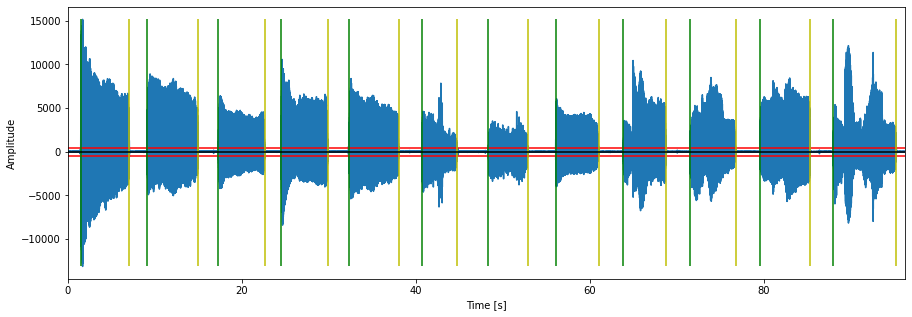

In [373]:
# Testeamos mostrando los resultados del Split

recording_index = 11  # Índice del split a mostrar

plot_segmented_audio(recordings[recording_index], 10 * default_threshold,
                     [recordings_segments_indexes[recording_index][i][0] for i in
                      range(len(recordings_segments_indexes[recording_index]))],
                     [recordings_segments_indexes[recording_index][i][1] for i in
                      range(len(recordings_segments_indexes[recording_index]))],
                     sampling_rate)

In [370]:
# Podemos escuchar algún segmento en particular
gc.collect()
testing_recording = filtered_recordings[recording_index][
                    recordings_segments_indexes[recording_index][registros['NEO']][0]:
                    recordings_segments_indexes[recording_index][registros['NEO']][1]]
Audio(testing_recording, rate=sampling_rate)

<source src="data:audio/wav;base64,UklGRiTDBwBXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YQDDBwDe+K/4jPht+EH4IvgK+N/3oPd99233Uvcn9//24PbB9qX2jfZ+9nb2XvY39i/2N/Yg9gD2/PX89fD1/PUM9gD29PX89Qz2EPYM9gj2FPYr9iv2K/Y79kf2T/Za9mr2dvaK9p32pfa99uD27PYL9zb3Rvda95H3tPe89+P3Gvg6+Fn4gPic+Lf43vj6+CH5TPlw+Z/52vn1+R36Z/qW+qb64fog+zP7V/uW+7X71PsX/EL8Svx5/LT8yPzb/Af9Lv1R/Xn9lP2o/c/9/v0d/jn+Uf50/pv+wv7i/vL+9f4B/xn/MP9E/1D/WP9z/5P/k/+P/6r/tv+6/9X/5f/V/+3/CwAAAPn/EwAHAOX/+f8AAOH/0f/Z/8r/yv/Z/7r/lv+m/57/c/9v/4v/e/9f/2v/e/9r/1//a/9v/3f/i/+u/9H/+f8fAEYAeQCsANQAAwFFAXwBswEdAnwCtwIlA7IDDARjBAsFsAUuBssGdAfyB48IPAmtCRQKrQouC5ALGgyjDA0Niw0gDp4OFA+hDxcQgRADEYQR5hFJEq8S8RIZE1QThxOWE6YTyRPlE/UTCBQkFCwUQxRXFEMUJBQsFBgU4RO+E5oTVBMZE+0SpxJcEjUS+hGnEXgRSREDEcgQmRBKEOwPmQ8/D+EOig4wDt4Nnw1UDQINuwyADEEM/gu8C3ELJgvUCoUKPwr4CbUJZwkJCcIIlwhYCAUI1gezB3QHNQcCB7AGWQYmBucFkQVOBRcF1QShBG4EKATxA8IDewNEAxkDzgKEAlgCGgLDAYwBUQHrAI0ASgADALr/e/88/wH/0v6b/lj+Dv67/Xz9Sf3//Kj8YvwX/Mn7kvtP++36mvpX+gn6vvl4+R351/ir+G34Kvj397D3TvcX9/T2pfZW9i/2APa99YL1SPX19K70g/RQ9A30z/OI80HzAvPH8nnyLvL78cTxhfFe8UfxF/Hd8K3wgvBX8DTwAfDO77Lvm+9371jvPO8Z7/bu1u677qfuj+5s7lHuSe5B7inuFu4S7hbuFu4W7iLuPe5c7nTul+637truBe8p70DvZO9/74/vtu/t7xDwP/CW8NnwAPFD8ZXx0PEb8oHy2/Iq84zz3vMp9IP06fRP9bn1I/aC9vf2fffr90X4r/gd+XD5xvks+pL66fpH+8X7M/x5/ND8Qv2g/e79Rf6f/vX+UP+P/67/2f8LACsAQgBqAJkA0AAHATYBVQFlAXgBkAGQAYgBnAGvAaABlAGcAYQBYQFhAVUBHgEOASoBIgEOASIBGgHzANQArAB1AFIAMwAAAN3/0f/C/57/f/9z/2f/SP8h/xH/Cf/i/r7+o/50/kH+Jf7q/Zj9Yf1C/RL96/zY/Lz8nfyB/G78Tvwn/AP8/Pvg+6X7ivuS+4L7dvuW+6n7vfsf/Jn84/w+/c/9Uf6+/jz/uv82ANQAfAElAvECxgOSBG4FVQYiB+YHvgieCX4KZQtFDCENBQ7lDsEPkRBZES0SDRPlE7UUiRVdFiUXxhdEGL4YOxmSGdEZJxpmGnoaoRrrGv8a8xoPGy4bJhsbGxcb+xrUGrEabhr8GZYZQxnZGFAY2heEFyUXtxZZFv8VlRUrFcEURxTFE0QTvhI1ErMRMhGsECsQpQ8gD6oOKA6qDVAN+gyEDBYMxwthC9gKYgrsCXYJDAmbCCUI0geQBz0H8gbHBpAGSgYLBtAFlQVaBQgFtQSSBG4EKATpA8YDngNvA0QDDQPeAs4CygKjAmwCRQIhAu4BrAFxAToBBwHbAKgAbQBKADMACwDV/5r/WP8Z/+r+p/5F/vL9rP1N/ef8kfwz/ND7hvs7++H6nvpr+iT6yvl8+S353viQ+Dr44/ec91L39/at9nL2FPay9XP1OPXd9If0WPQh9NLziPM98+fylPJW8hPyzPGR8VbxEPHZ8Knwb/A88Ajwwu9370DvBe+r7lzuHu7X7YHtOu377MTskexi7DPsE+wL7ADs3OvU69zrxeuh663rxeu567Xr0evg6+jrC+wv7ELsYuyJ7LDs4OwP7Trtbe207QbuUe6b7uruPO+P7/HvY/C58ADxXvHM8SbyefLb8jXzlPMG9HD01vRP9cH1K/ap9i73iffn9134u/gR+Yv59fk4+pL6BPtb+7H7G/x1/Mj8Mv2Y/d/9If5s/q/+4v4V/0T/Y/+L/8r//f8AAAcAIwAnACsASgBWAEoAVgBaAC8ABwAAANn/mv9v/zj/8v7C/pP+WP4h/ur9rP2M/XX9Ov0D/ef8xPyh/IX8SvwA/ND7rfty+zv7CPvJ+pr6ivpv+jD67fnW+c75o/lk+UX5LfkK+fb42/iY+HT4fPhZ+B74Ivgm+PP33/fn97j3dfda9zL39/bk9tj2ufax9r32vfbB9tj2+/Yr9233uPcS+Iz4CvmP+TD66fqZ+0r8Mv1F/lT/bQCzAfUCJARqBagGoweqCOAJ7ArbCwkNRA5eD6QQHRJfE5kUFhZ8F7oYFxp5G6cczh3sHsQfaSAaIa8hHSKPIgUjXyO6IyAkeiS5JPQkJyVGJVIlTiUrJewknSQ7JMUjTyPSIkEisyE1IbAgIyCxH0cfxR48HqodCR1kHLQb4BoMGlcZmhjeFzkXkBbbFUIVuRQUFHMT4hJFEqsRHhGBEMgPGA9jDqoN/gxhDMsLRgvMCl4KAAqeCTwJ6QiDCAUIpwdRB9MGZQY2BvcFtAWlBZkFdgV5BY0FagVGBUYFLwX0BMUEngRjBDQEBATCA5oDmgOWA4MDkgOqA6oDpgOmA5IDXAMRA8ICbAIKApgBLgHMAF4A5f93/x3/r/49/u79oP0q/cD8avwD/IL7BPuH+v35h/kZ+av4TfgD+Kj3Qvfs9o32IPa19UD1tvQ19MPzRfPD8kbyzPFe8QzxufBb8Ajw1e+X70Dv/e7D7nDuDu677W3tE+3A7HnsK+zc647rP+vt6pbqJeq66Vzp7uht6A7o1OeV52LnRuc+5z7nTudt553nxOff5w7oSeht6Izor+i36K/ox+jf6Nvo6ugp6WTpp+kB6mPqwuok647rBOx57O/sae367YDu7u5g79nvS/DJ8E7x1PFW8s/yRfPH80z0n/Th9ET1ovXh9TP2mfb09lL3yPcy+JT4Bvl4+dL5JPqD+uH6KPtX+4771PsT/Er8gfys/Nv8Hv1d/Yj9sP3H/dP96v3u/b/9oP2k/ZT9af1J/Tb9Iv0i/Rb98/zf/Nv8xPyk/HH8K/z8+8X7R/vF+o76UPra+Yv5ZPkp+fr44vi3+KT4t/in+Hj4ePh4+EH4GvgW+PP3zPfP98/3tPe098D3rPec96T3oPeR95j3mPeN95j3qPeN9433wPfb99v3CvhJ+Fn4fPi/+Mf4q/i7+M/4t/ic+Hz4Rfgy+E34TfhJ+JD48vhU+en5lvor++j72Py//a/+zf/nAAICSAOOBMQFNQe+CBAKVgvDDAkOJw91ELsRxhL8E2YVrBbuF3IZ8xpNHNIdZh/LICEiiiPMJNQl1yazJ1Ao2ShfKbUp5CkPKjMqUipmKnUqfSqBKnIqViovKuQpgikgKaIo/SdgJ9cmNiaJJewkRySaIwkjgyLiISohgSDkHy8fUx5sHZQcvxvIGsUZ1Rj1FyUXdRa4FeQUNxS+EzgThxLmEUkRjRDUDy8Paw6XDe4MSQyBC8gKQwq1CSQJsghACLsHTQfnBmUG8wWpBVYFAAXgBNUEtQShBJoEggRqBGcEQwQEBOEDzQOaA2MDPAMJA9oCswJ8AlQCUAJQAjkCOQJNAjEC+gHfAagBPgHvALwAQgCu/1T/9f5g/t/9bf3Y/Fr8C/yO+/X6mvpI+rL5JfnH+EH4sPdS9+j2R/bJ9Xf1AfV79A30lPMG85DyH/KB8ejwZ/DZ70Tvxu5V7t/tbe0P7bzscuwz7

In [10]:
# Guardo los índices de los splits en un archivo excel usando Pandas

assert 'recordings_segments_indexes' in globals(), 'No se han obtenido los índices de los segmentos'

split_times_columns_matrix = []
for segments_indexes in recordings_segments_indexes:
    split_times = []
    for i in range(24):
        split_times.append(segments_indexes[i // 2][i % 2])
    split_times_columns_matrix.append(split_times)

split_times_columns_names = [
    f'{"start" if not index % 2 else "stop"}_{"0" if index // 2 + 1 < 10 else ""}{index // 2 + 1}'
    for index in range(24)]

split_times_dataframe = pd.DataFrame(split_times_columns_matrix, columns=split_times_columns_names)
split_times_dataframe.to_csv(r'/data/notebook_files/segments/split_times.csv', index=False)
split_times_dataframe

start_01 
 stop_01 
 start_02 
 stop_02 
 start_03 
 stop_03 
 start_04 
 stop_04 
 start_05 
 stop_05 
 ... 
 start_08 
 stop_08 
 start_09 
 stop_09 
 start_10 
 stop_10 
 start_11 
 stop_11 
 start_12 
 stop_12 
 
 
 
 
 
 0 rows × 24 columns

In [12]:
# Guardo los segmentos de audio

assert 'recordings_segments_indexes' in globals(), 'No se han obtenido los índices de los segmentos'

for recording_index, segments_indexes in enumerate(recordings_segments_indexes):
    for key_index, key in enumerate(registros.keys()):
        wf.write(
            rf'/data/notebook_files/segments/{key}_{"0" if recording_index + 1 < 10 else ""}{recording_index + 1}.wav',
            sampling_rate,
            filtered_recordings[recording_index][segments_indexes[key_index][0]:segments_indexes[key_index][1]])

## Densidad espectral de potencia de cada segmento para cada letra y palabra
Una vez segmentado todos los audios, proseguimos a cargarlos para su posterior procesamiento. En esta seccion y las siguientes se buscaran las transformadas en frecuencia y luego las diferentes densidades espectrales vistas en la catedra.

In [13]:
# Se puede importar directamente los segmentos

segments_folder_path = '/data/notebook_files/segments/'

recordings_segments = []
if 'recordings_segments_indexes' in globals() and not 'imported_from_files' in globals() and 'recordings' in globals():
    for recording_index, segments_indexes in enumerate(recordings_segments_indexes):
        recording_segments = []
        for segment_indexes in segments_indexes:
            recording_segments.append(recordings[recording_index][segment_indexes[0]:segment_indexes[1]])
        recordings_segments.append(recording_segments)
else:
    recordings_segments = []
    for recording_index in range(12):
        recording_segments = []
        for key in registros:
            recording_segments.append(wf.read(
                rf'{segments_folder_path}{key}_{"0" if recording_index + 1 < 10 else ""}{recording_index + 1}.wav')[1])
        recordings_segments.append(recording_segments)
    else:
        sampling_rate = \
            wf.read(rf'{segments_folder_path}A_{"0" if recording_index + 1 < 10 else ""}{recording_index + 1}.wav')[0]
    imported_from_files = True

# recording_segments contiene listas con con los segmentos de cada grabación
assert len(recordings_segments) == 12, 'No se han importado bien los segmentos'

AssertionError: AssertionError: No se han importado bien los segmentos

## Densidad espectral promedio para cada letra y palabra
En el siguiente codigo se pueden encontrar las diversas funciones para realizar las densidades espectrales para los casos parametricos. Por ultimo se desarrolla una funcion para poder graficar las diversas señales frecuenciales en cuestion

In [7]:
def correlogram(signal, rate, norm='biased') -> Tuple[np.ndarray, np.ndarray]:
    """
    Funcion de correlograma que consiste en hacer la transformada de Fourier del estimador de autocorrelacion
        
    INPUT: 
        señal_entrante: Es un array, que consistirá en los segmentos de señal deseada de los audios.
        N: Real y positivo. Permite normalizar a la autocorrelacion de manera diversa en el centro y en las puntas y asi este sea insesgado
        opcion: Numero Real. Permite elegir entre la autocorrelacion insesgada y sesgada
        
    OUTPUT
        w1: Es un array, que contiene las frecuencias correspondientes de la transformada de Fourier
        Sxx1: Es un espectro de frecuencia, es la transformada de la autocorrelacion (sesgada o insesgada).Es un array de numeros complejos

    """
    signal = signal.astype('float64')
    signal_length = len(signal)
    rxx = sig.correlate(signal, signal, method='fft')
    if norm == 'unbiased':
        for index, value in enumerate(rxx):
            lag = index - signal_length + 1
            rxx[index] = value / (signal_length - abs(lag))
    elif norm == 'biased':
        rxx /= signal_length

    # Transformamos para obtener el PSD
    signal_correlogram = fft(rxx)
    # Obtengo las frecuencias correspondientes
    frequencies = fftfreq(len(signal_correlogram), 1 / rate)
    return frequencies, np.abs(signal_correlogram)


def periodogram(signal, rate) -> Tuple[np.ndarray, np.ndarray]:
    """
    Funcion de periodograma que consiste en hacer la transformada de Fourier de la señal y luego obtener el cuadrado de su modulo
        
    INPUT: 
        señal_entrante: Es un array, que consistira en los segmentos de señal deseada de los audios.
        N: Real y positivo. Permite normalizar a la autocorrelacion de manera diversa en el centro y en las puntas y asi este sea insesgado
        opcion: Numero Real. Permite elegir entre la autocorrelacion insesgada y sesgada. Tambien es el intervalo de medicion de frecuencia        w1: Es un array, que contiene las frecuencias correspondientes de la transformada de Fourier
        
    OUTPUT:
        Sp: Es el espectro de frecuencia , es la transformada de la autocorrelacion (sesgada o insesgada). Es un array de numeros complejos
        w: son las frecuencias correspondientes de Sp, es un array de numeros reales
    """
    signal.astype('float64')
    signal_length = len(signal)
    signal_periodiogram = np.abs(fft(signal)) ** 2 / signal_length
    frequencies = fftfreq(len(signal_periodiogram), 1 / rate)
    return frequencies, signal_periodiogram


def blackman(signal, rate) -> Tuple[np.ndarray, np.ndarray]:
    """
    Funcion de periodograma-BLACKMAN que consiste en hacer la transformada de fourier de la autocorrelacion truncada conuna ventana
        
    INPUT: 
        señal_entrante: Es un array, que consistira en los segmentos de señal deseada de los audios.
        N: Real y positivo. Permite normalizar a la autocorrelacion de manera diversa en el centro y en las puntas y asi este sea insesgado
        opcion: Numero Real. Permite elegir entre la autocorrelacion insesgada y sesgada. Tambien es el intervalo de medicion de frecuencia        w1: Es un array, que contiene las frecuencias correspondientes de la transformada de Fourier
       
    OUTPUT:
        Sp: Es el espectro de frecuencia , es la transformada de la autocorrelacion (sesgada o insesgada). Es un array de numeros complejos
        w son las frecuencias correspondientes de Sp, es un array de numeros reales

    """
    signal = signal.astype('float64')
    signal_length = len(signal)
    rxx = sig.correlate(signal, signal, method='fft')
    win = np.blackman(len(rxx))
    rxx = rxx * win.astype('float64') / float(signal_length)
    blackman_correlogram = fft(rxx)
    frequencies = fftfreq(len(blackman_correlogram), 1 / rate)
    return frequencies, np.abs(blackman_correlogram)


def bartlett(signal, n_segments, rate) -> Tuple[np.ndarray, np.ndarray]:
    """
    Funcion de bartlet, consiste en tomar el modulo al cuadrado de la transformada de Fourier pero se divide a la señal en segmentos
    
    INPUT
        n_segments: Numero real, que establece la cantidad de los segmentos a estimar.
        ssignal: Es un array, que consistira en los segmentos de señal deseada de los audios.
    
    OUTPUT
        periodograma:Array, que contiene a los espectros de frecuencia de cada uno de los segmentos
    """
    signal = signal.astype('float64')
    signal_length = len(signal)
    length_segments = signal_length // n_segments
    sum_periodograms = periodogram(signal[:length_segments], rate)[1]
    for next_index in range(1, n_segments):
        sum_periodograms += periodogram(signal[next_index * length_segments: (next_index + 1) * length_segments], rate)[
            1]
    frequencies = fftfreq(len(sum_periodograms), 1 / rate)
    prom_periodograms = sum_periodograms * (1 / n_segments)
    return frequencies, prom_periodograms


def welch(signal, segment_length, rate, overlap=None) -> Tuple[np.ndarray, np.ndarray]:
    """
    TODO
    """
    frequencies, welch_periodogram = sig.welch(signal, rate, nperseg=segment_length,
                                               nfft=segment_length, noverlap=overlap)
    return frequencies, welch_periodogram


def wiener(signal, N):
    raise NotImplemented('No se implementó todavía')
    b = np.zeros(N - 1)
    a = (np.insert(x, 0, b))
    return (np.convolve(a, np.ones(N), 'valid')) / N


def get_positive_freqs_psd(psd: Tuple[np.ndarray, np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
    """
    TODO
    """
    frequencies = psd[0]
    psd_itself = psd[1]
    if frequencies[-1] < 0:
        last_positive = int(np.ceil(len(frequencies) / 2))
        return frequencies[:last_positive], psd_itself[:last_positive]
    else:
        return frequencies, psd_itself


def get_positive_freqs_psds_matrix(psds_matrix: List[List[Tuple[NDArray, NDArray]]]) -> None:
    """
    TODO
    """
    for recording_index in range(len(psds_matrix)):
        for register_index in range(len(psds_matrix[recording_index])):
            psd = psds_matrix[recording_index][register_index]
            psds_matrix[recording_index][register_index] = get_positive_freqs_psd(psd)


def plot_spectral_density(spectral_densities_matrix,
                          samples_titles=None, fig_title=None, labels=None, max_freq_and_rate=None, colors=None,
                          has_only_pos_freqs=False):
    """
    TODO
    """
    #Limpiamos la memoria
    gc.collect()
    differents = len(spectral_densities_matrix[0])
    samples = len(spectral_densities_matrix)
    #Creamos un grafico de una sola columna y de una cantidad de filas igual a la cantidad de elementos dentro de un unico recording
    fig_spectral_densities, ax_spectral_densities = plt.subplots(differents, 1, figsize=(15, 5 * differents), num=1)
    for ax_index, ax in enumerate(ax_spectral_densities):
        for sample in range(samples):
            freqs, psd = spectral_densities_matrix[sample][ax_index]
            if not has_only_pos_freqs:
                if max_freq_and_rate:
                    max_freq = max_freq_and_rate[0]
                    rate = max_freq_and_rate[1]
                    len_freqs = len(freqs)
                    #Tomamos un segmento de frecuencias relevante
                    freqs = freqs[:int(np.ceil(len_freqs / 2) * max_freq * 2 / rate)]
                    psd = psd[:int(np.ceil(len_freqs / 2) * max_freq * 2 / rate)]
                else:
                    len_freqs = len(freqs)
                    freqs = freqs[:int(np.ceil(len_freqs / 2))]
                    psd = psd[:int(np.ceil(len_freqs / 2))]
            else:
                if max_freq_and_rate:
                    max_freq = max_freq_and_rate[0]
                    rate = max_freq_and_rate[1]
                    len_freqs = len(freqs)
                    #Tomamos un segmento de frecuencias relevante
                    freqs = freqs[:int(len_freqs * max_freq * 2 / rate)]
                    psd = psd[:int(len_freqs * max_freq * 2 / rate)]
            if labels is not None and colors is not None:
                ax.plot(freqs, psd, color=colors[sample], label=labels[sample])
            elif labels is not None:
                ax.plot(freqs, psd, label=labels[sample])
            elif colors is not None:
                ax.plot(freqs, psd, color=colors[sample])
            else:
                ax.plot(freqs, psd)
        if labels is not None:
            ax.legend()
        if samples_titles is not None:
            ax.set_title(samples_titles[ax_index])
    fig_spectral_densities.add_gridspec()
    fig_spectral_densities.supxlabel('Frequency [Hz]')
    fig_spectral_densities.supylabel('PSD')
    fig_spectral_densities.tight_layout(rect=[0, 0.02, 1, 0.97])
    if fig_title is not None:
        fig_spectral_densities.suptitle(fig_title, fontsize=20)
    fig_spectral_densities.show()

In [9]:
# Especificaciones previo a calcular las psds
max_freq_rate = (1500, sampling_rate)
titles = list(registros.keys())
n_segments_bartlet = 10
segments_length_welch = (len(recordings_segments[0][0])) / 10
psds_colors = ['red', 'orange', 'yellow', 'green', 'blue', 'cyan', 'purple', 'violet', 'magenta', 'black', 'gold',
               'pink']


ModuleNotFoundError: ModuleNotFoundError: No module named 'sampling_rate'

# Graficos de las densidades espectrales
A continuacion se prosigue por realizar los graficos de cada uno de los segmentos (tanto de las letras como palabras) usando los diversos metodos. Para su realizacion una vez que se obtiene el espectro habiendo utilizado algunos de los metodos, se obtienen solamente sus frecuencias positivas (ya que las funciones utilizadas tambien retornan frecuencias negativas, pero estas no son de interes fisico)

### Correlogramas

In [152]:
# Correlograma insesgado
#biased_correlograms = \
#    [[correlogram(recordings_segments[i][j], 'unbiased') for j in range(len(registros))] for i in range(len(recordings_segments))]

# Correlograma sesgado
biased_correlograms_spds = \
    [[correlogram(recordings_segments[i][j], sampling_rate) for j in range(len(registros))] for i in
     range(len(recordings_segments))]

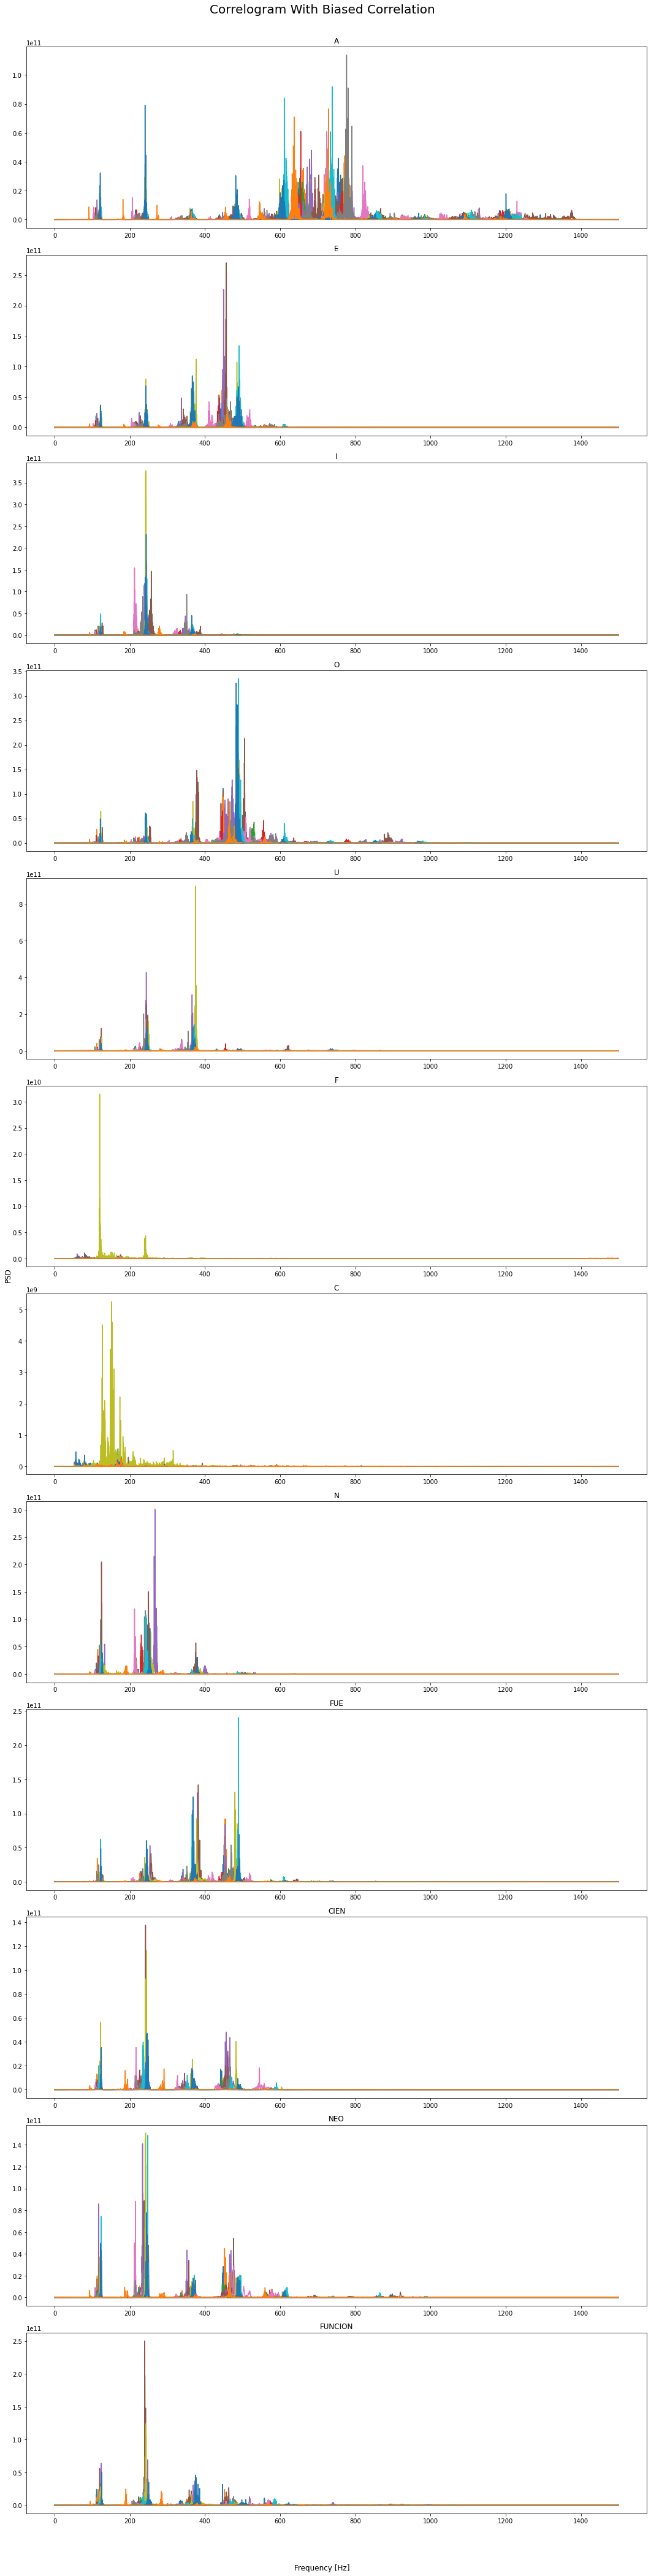

In [153]:
get_positive_freqs_psds_matrix(biased_correlograms_spds)
plot_spectral_density(biased_correlograms_spds, list(registros.keys()),
                      fig_title='Correlogram With Biased Correlation', max_freq_and_rate=(1500, sampling_rate),
                      has_only_pos_freqs=True)

### Periodogramas

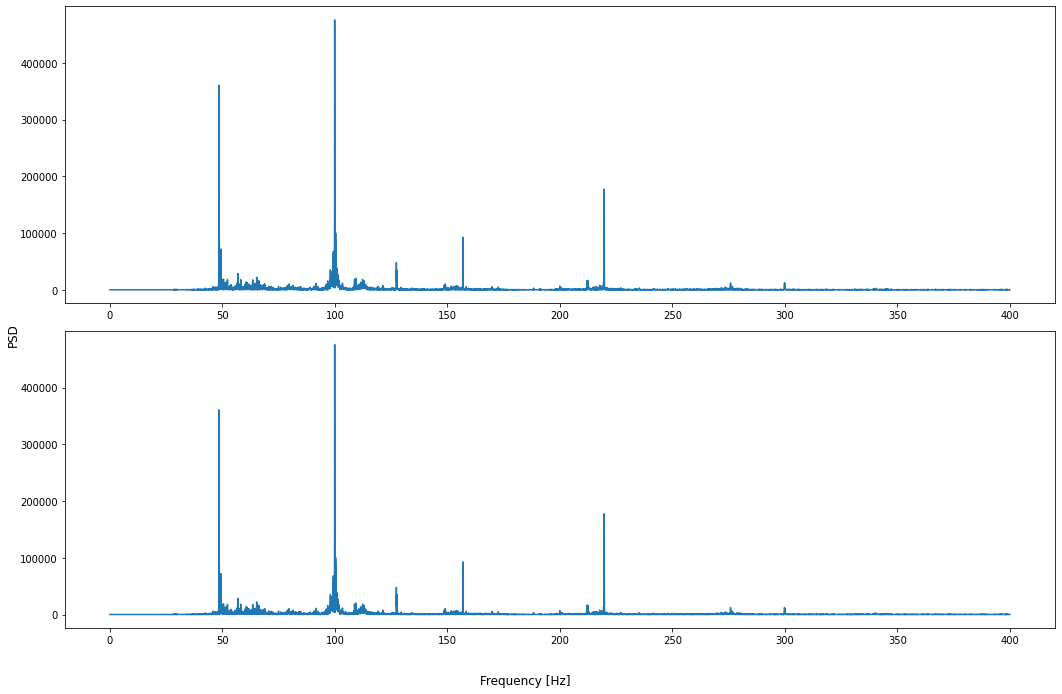

In [68]:
noise_psds = [[periodogram(noise_recording, sampling_rate), periodogram(noise_recording, sampling_rate)]]
get_positive_freqs_psds_matrix(noise_psds)
plot_spectral_density(noise_psds, max_freq_and_rate=(500, sampling_rate),
                      has_only_pos_freqs=True)

In [34]:
periodogram_psds = \
    [[periodogram(recordings_segments[i][j], sampling_rate) for j in range(len(registros))] for i in
     range(len(recordings_segments))]

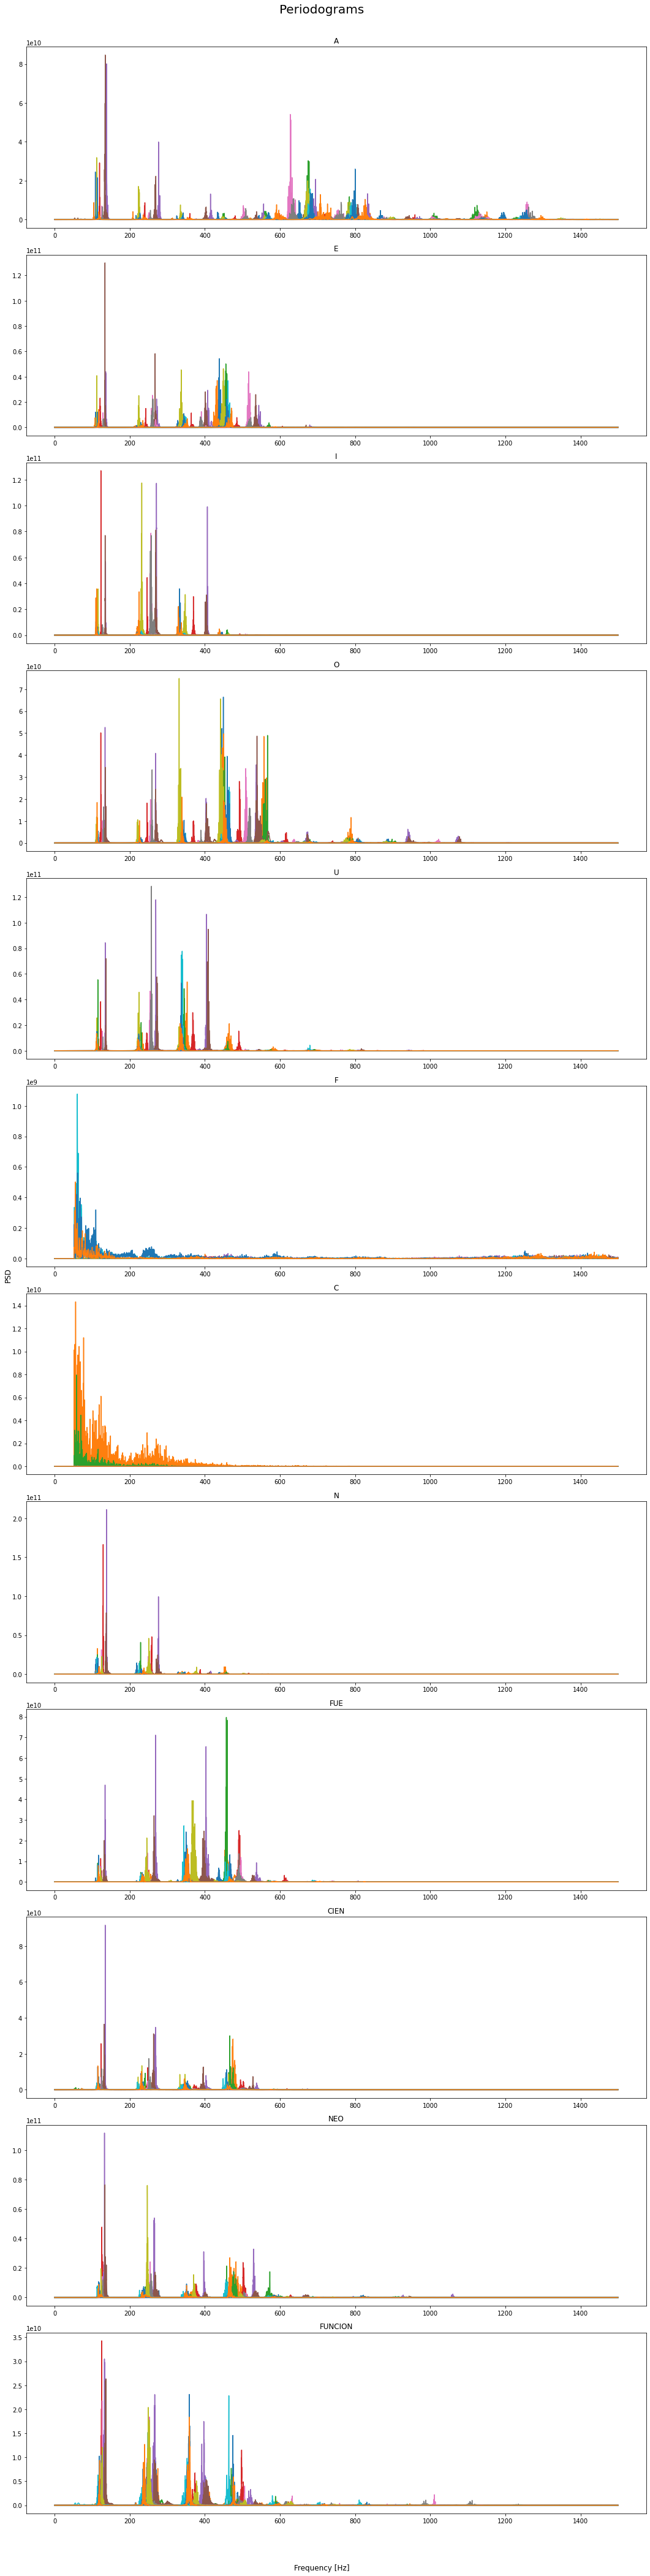

In [35]:
get_positive_freqs_psds_matrix(periodogram_psds)
plot_spectral_density(periodogram_psds, titles,
                      fig_title='Periodograms', max_freq_and_rate=(1500, sampling_rate),
                      has_only_pos_freqs=True)

### Método de Blackman

In [159]:
blackman_psds = \
    [[blackman(recordings_segments[i][j], sampling_rate) for j in range(len(registros))] for i in
     range(len(recordings_segments))]

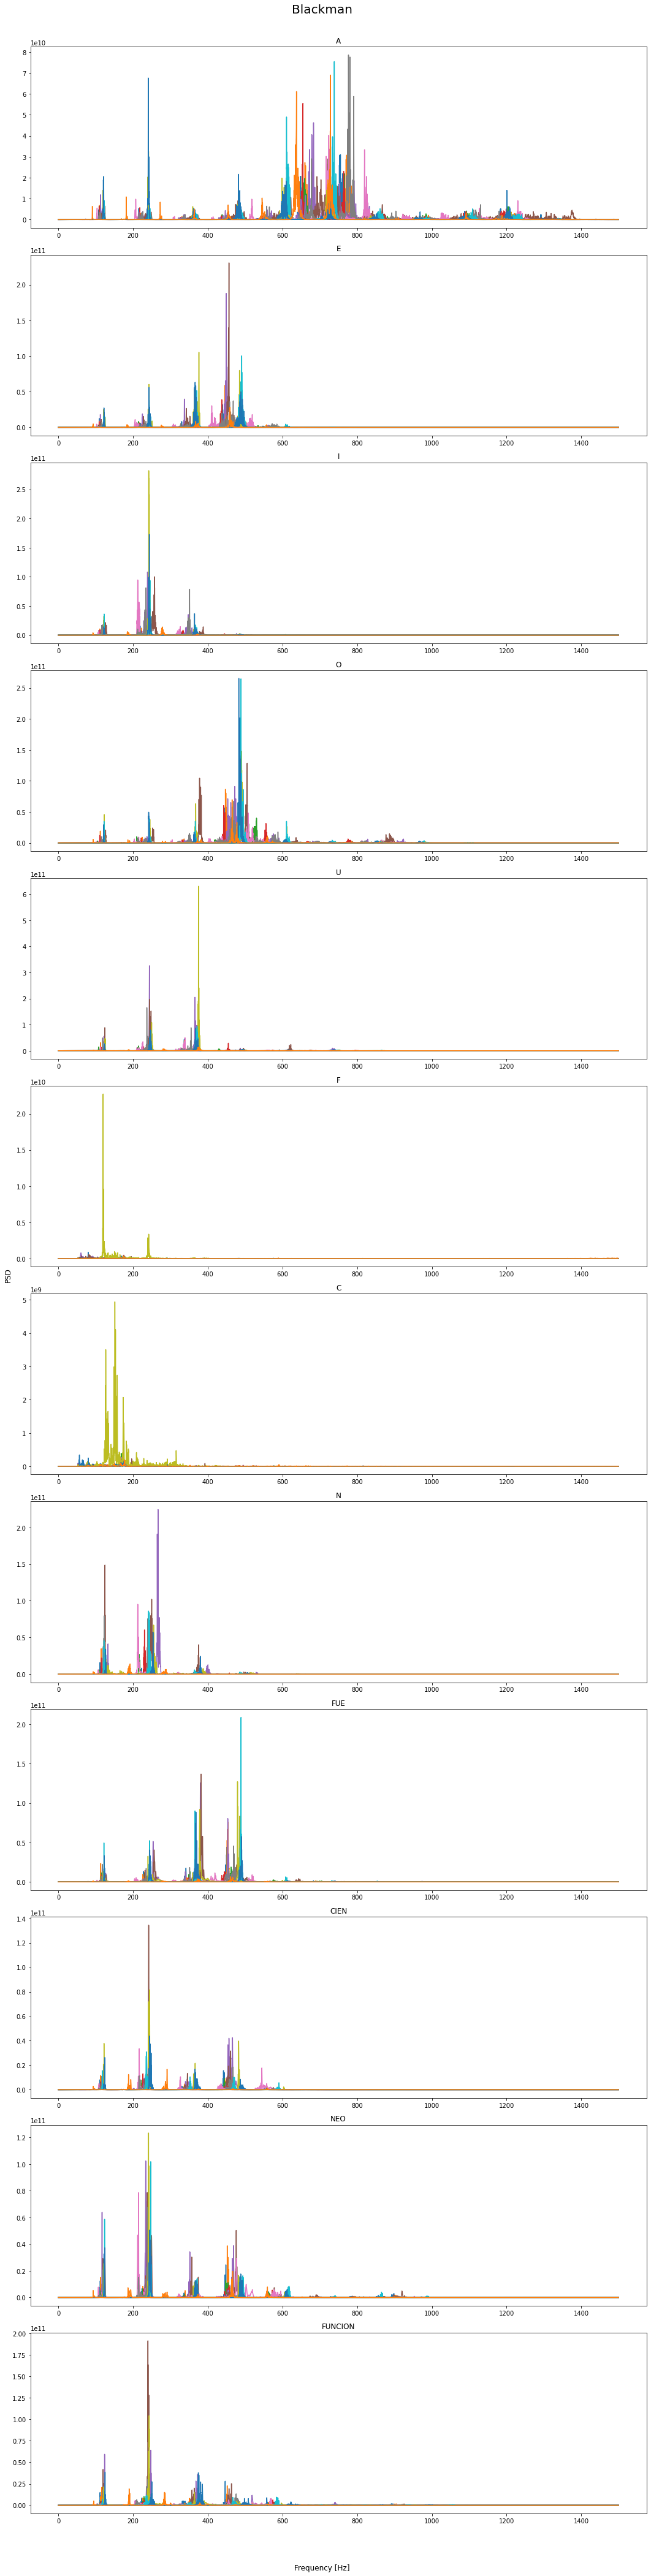

In [160]:
get_positive_freqs_psds_matrix(blackman_psds)
plot_spectral_density(blackman_psds, samples_titles=titles, fig_title="Blackman", labels=None,
                      max_freq_and_rate=max_freq_rate,
                      has_only_pos_freqs=True)

### Método de Bartlett

In [155]:
bartlett_psds = \
    [[bartlett(recordings_segments[i][j], n_segments_bartlet, sampling_rate) for j in range(len(registros))] for i in
     range(len(recordings_segments))]

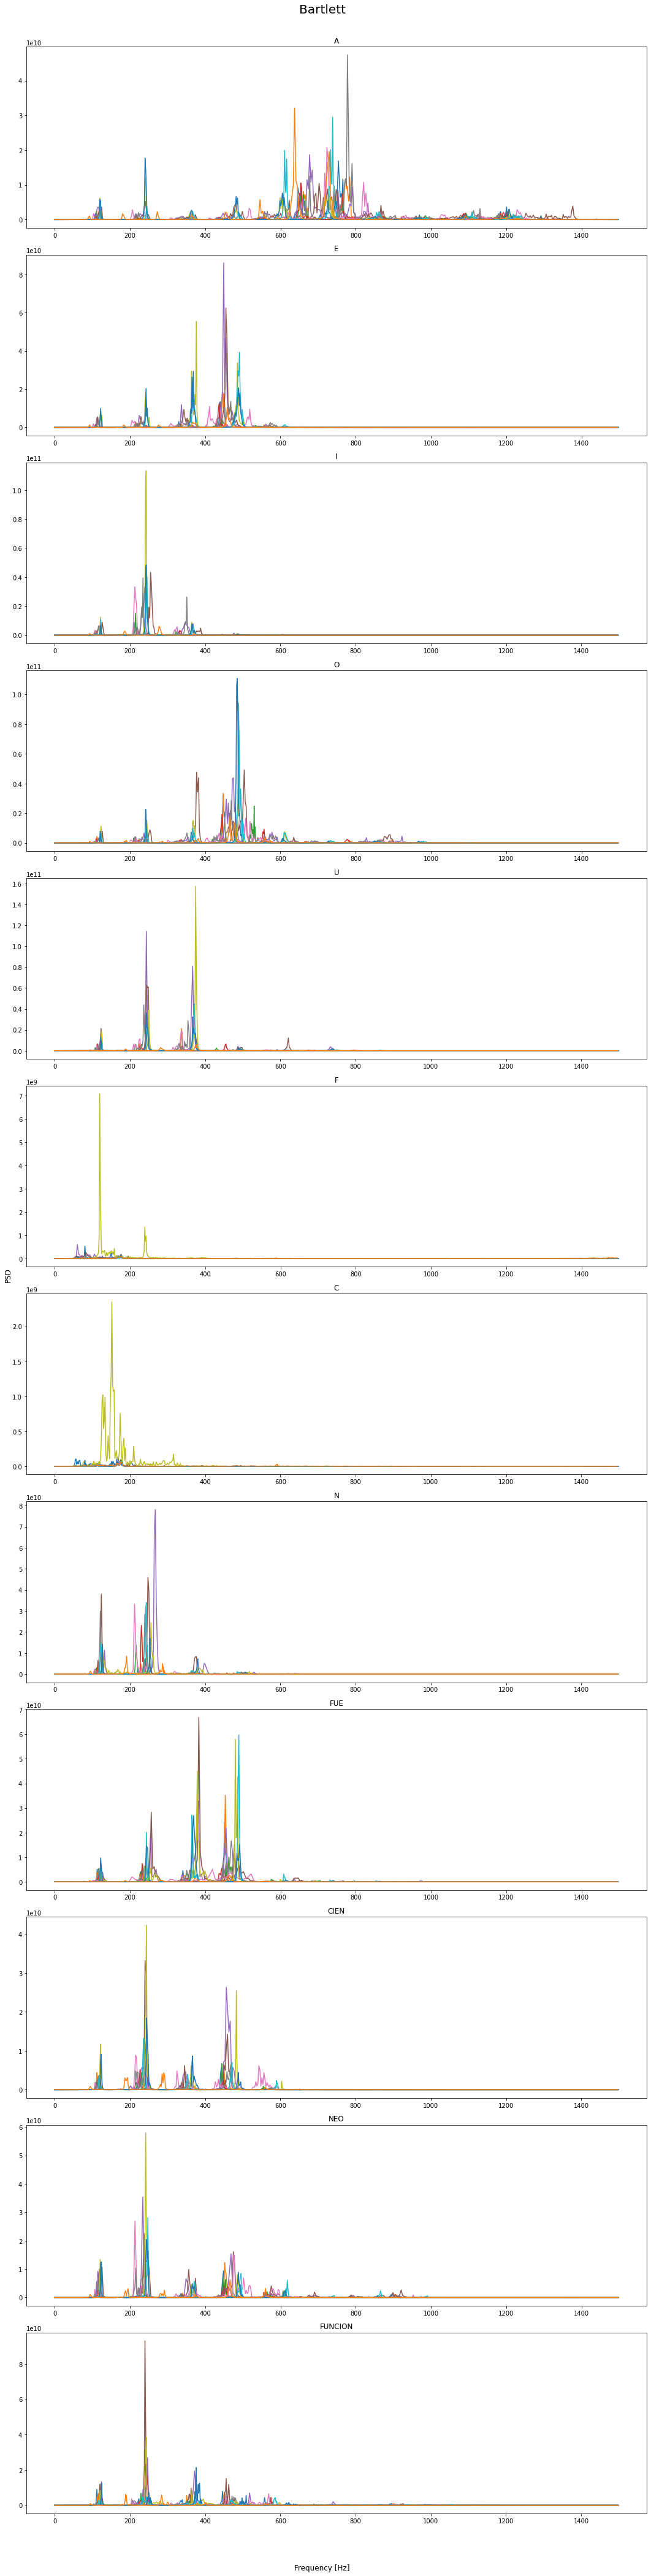

In [157]:
get_positive_freqs_psds_matrix(bartlett_psds)
plot_spectral_density(bartlett_psds, samples_titles=titles, fig_title="Bartlett", labels=None,
                      max_freq_and_rate=max_freq_rate, has_only_pos_freqs=True)

###  Método de Welch

In [36]:
welch_psds = \
    [[welch(recordings_segments[i][j], segments_length_welch, sampling_rate) for j in range(len(registros))] for i in
     range(len(recordings_segments))]

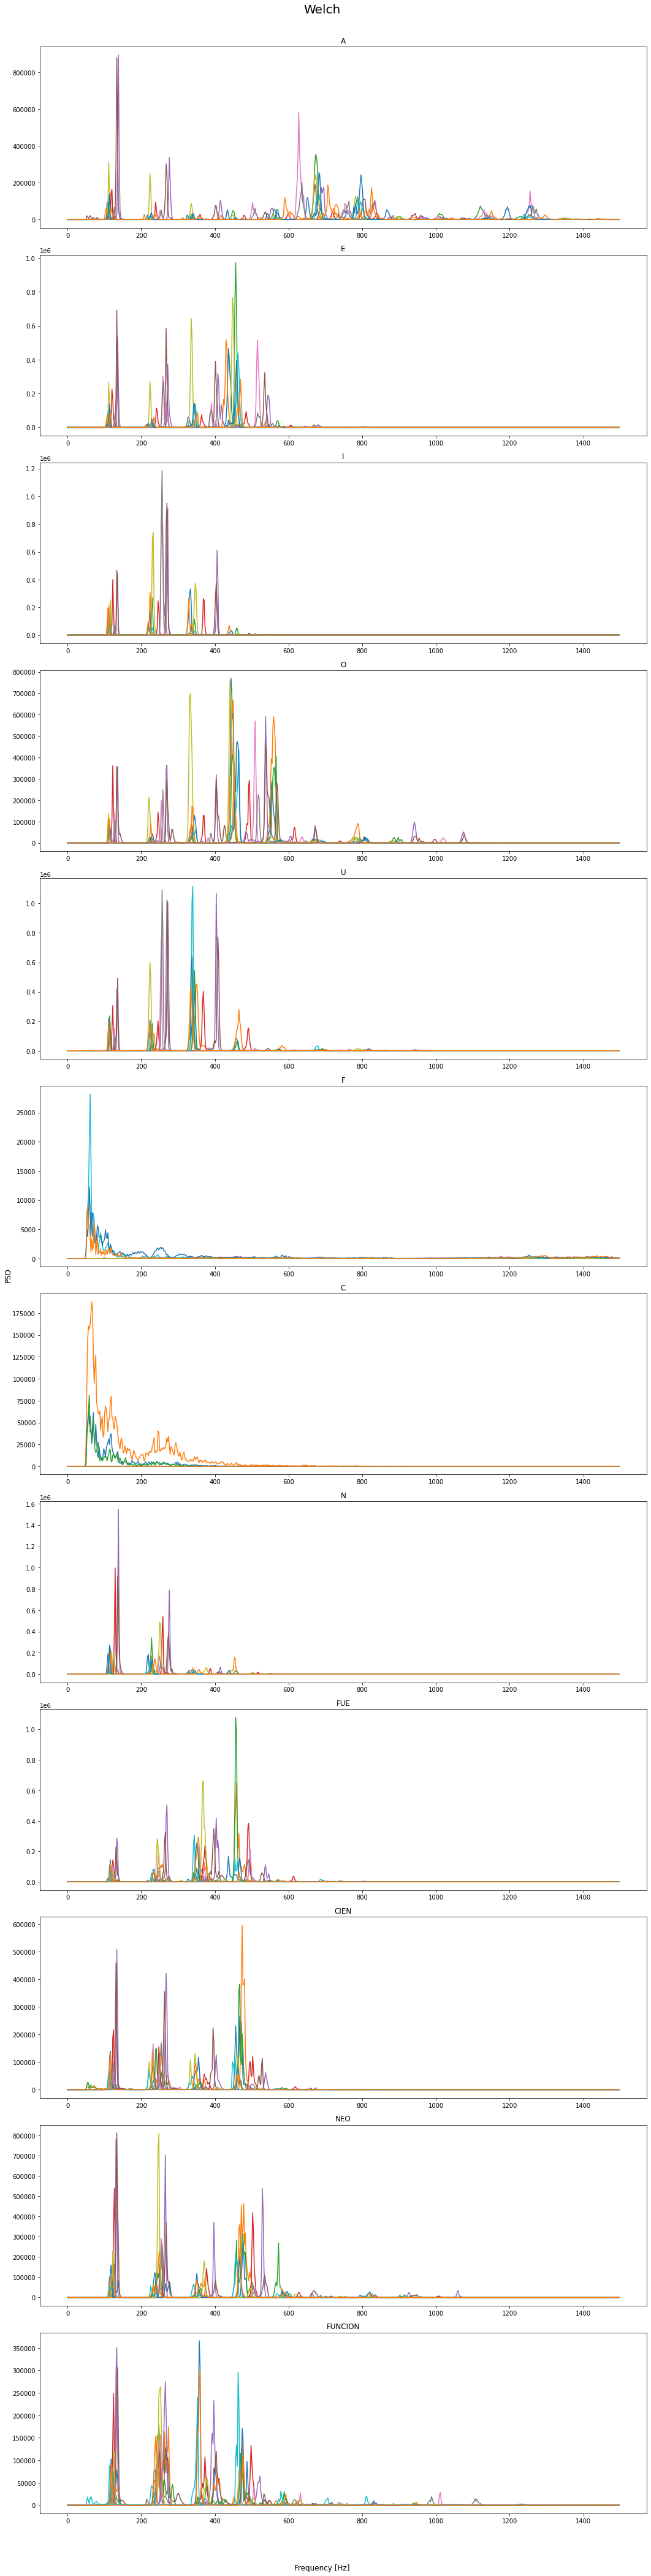

In [37]:
#Para welch hay que usar un eje x distinto al resto dado a que su psds devuelve un rango de frecuencias distintos al resto
get_positive_freqs_psds_matrix(welch_psds)
plot_spectral_density(welch_psds, samples_titles=titles, fig_title="Welch", labels=None,
                      max_freq_and_rate=max_freq_rate,
                      has_only_pos_freqs=True)

## Metodos Parametricos

Al igual que en el punto anterior, se desarrollan las funciones para los metodos parametricos para realizar los espectros de frecuencia.

### Yule Walker

In [36]:
Fs = sampling_rate
order = 10


def yule_walker_coeffs(x, L):
    # Armo la matriz R
    rxx = plt.acorr(x, maxlags=L)[1]
    rxx = rxx[L:]
    Rxx = toeplitz(rxx[:-1])  # Rxx es la matriz

    # Encuentro coef (son los coeficientes, los pesos)
    coef = -(np.linalg.solve(Rxx, rxx[1:]))  # Resolver Rxx*a=rxx, rxx es una matriz de (L+1x1)
    coef = np.insert(coef, 0, 1)  # Inserto el 1 en el vector a en la posición 0

    return coef  # esta funcion me devuelve los coef


def Y_W(audio_signal):
    pos_Frecuencias = []
    pos_Coefs = []
    Frecuencias = []
    Coefs = []

    ar_coeffs = yule_walker_coeffs(audio_signal, order)
    numerator = [np.var(audio_signal)]
    denominator = ar_coeffs

    x = lfilter(numerator, denominator, audio_signal)

    frequencies = fftfreq(len(x), 1 / Fs)
    ar_psd = np.abs(fft(x))

    pos_Frecuencias, pos_Coefs = get_positive_freqs_psd([frequencies, ar_psd])

    for i in range(7000):
        Frecuencias.append(pos_Frecuencias[i])
        Coefs.append(pos_Coefs[i])

    return Frecuencias, Coefs

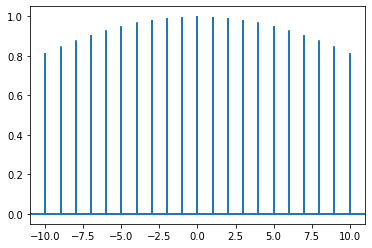

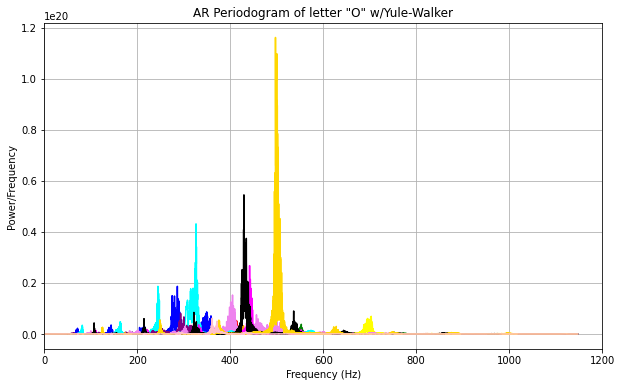

In [37]:
a = Y_W(recordings_segments[0][3].astype('float64'))[0]
b = Y_W(recordings_segments[0][3].astype('float64'))[1]
x = [a, b]

for i in range(1, 12):
    x.append(Y_W(recordings_segments[i][3].astype('float64'))[1])

# Ploteamos el priodograma
plt.figure(figsize=(10, 6))
for i in range(1, 13):
    plt.plot(x[0], x[i], color=psds_colors[i - 1])
plt.title('AR Periodogram of letter "O" w/Yule-Walker')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency')
plt.xlim(0, 1200)
plt.grid(True)
plt.show()

### Levison-Durbin

In [70]:
Fs = sampling_rate
order = 10


def levinson_durbin(x, L):
    R = [x.dot(x)]
    # Calculo la autocorrelación
    for i in range(1, L + 1):
        r = x[i:].dot(x[:-i])
        R.append(r)
    R = np.array(R)

    # Pasos Levinson-Durbin
    C = np.array([1, -R[1] / R[0]])
    P = R[0] + R[1] * C[1]

    for i in range(1, L):
        ki = (-1) * C[:i + 1].dot(R[i + 1:0:-1]) / P
        C = np.hstack([C, 0])
        C = C + ki * C[::-1]
        P = P * (1 - ki ** 2)

    return C


def L_V(audio_signal):
    pos_Frecuencias = []
    pos_Coefs = []
    Frecuencias = []
    Coefs = []

    ar_coeffs = levinson_durbin(audio_signal, order)
    numerator = [np.var(audio_signal)]
    denominator = ar_coeffs

    x = lfilter(numerator, denominator, audio_signal)

    frequencies = fftfreq(len(x), 1 / Fs)
    ar_psd = np.abs(fft(x))

    pos_Frecuencias, pos_Coefs = get_positive_freqs_psd([frequencies, ar_psd])

    for i in range(10000):
        Frecuencias.append(pos_Frecuencias[i])
        Coefs.append(pos_Coefs[i])

    return Frecuencias, Coefs

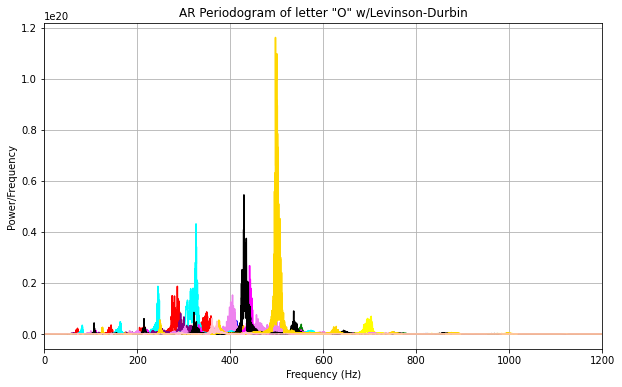

In [72]:
a = L_V(recordings_segments[0][3].astype('float64'))[0]
b = L_V(recordings_segments[0][3].astype('float64'))[1]
x = [a, b]

for i in range(1, 12):
    x.append(L_V(recordings_segments[i][3].astype('float64'))[1])

psds_colors = ['blue', 'orange', 'yellow', 'green', 'red', 'cyan', 'purple', 'violet', 'magenta', 'black', 'gold',
               'pink']

# Ploteamos el priodograma
plt.figure(figsize=(10, 6))
for i in range(1, 13):
    plt.plot(x[0], x[i], color=psds_colors[i - 1])
plt.title('AR Periodogram of letter "O" w/Levinson-Durbin')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency')
plt.xlim(0, 1200)
plt.grid(True)
plt.show()

## Centrado y promediación de las PSDs

Una vez obtenidos los espectros de frecuencia se prosiguio por realizar el centrado de cada uno de los graficos. Se busco dimensionar en unna misma longitud a cada funcion y una vez hecho esto elegir  una de las grabaciones  como plantilla.  Luego se correlaciono al resto de las funcionescon esta plantilla para que todas queden centradas y alineades  segun estas

Una vez que se obtienen los graficos centrados el siguiente paso es promediarlo. De esta forma cada letra y palabra se fusiona en una unica funcion de modo de poder definir de manera clara la frecuencias dominantes y el rango de las mismas

In [3]:
def get_longest_array(psds_matrix, sample):
    max_length = 0
    max_length_index = 0
    for recording_index in range(len(psds_matrix)):
        length = len(psds_matrix[recording_index][sample][0])
        if length > max_length:
            max_length = length
            max_length_index = recording_index
    return max_length, max_length_index


# Funcion de mapeo de interpolacion
def normalize_length_psds(psds_matrix) -> List[List[Tuple[np.ndarray, np.ndarray]]]:
    """
    TODO
    """
    normalized_length_psds_matrix = []

    max_length_s = []
    frequencies_max_length_s = []
    for register_index in range(len(psds_matrix[0])):
        max_length, max_length_index = get_longest_array(psds_matrix, register_index)
        frequencies_max_length = psds_matrix[max_length_index][register_index][0]
        max_length_s.append(max_length)
        frequencies_max_length_s.append(frequencies_max_length)

    for recording_index in range((len(psds_matrix))):
        normalized_length_recording_psds = []
        for register_index in range(len(psds_matrix[0])):
            freqs, psd = psds_matrix[recording_index][register_index]
            new_indexes = np.linspace(0, len(freqs) - 1, max_length_s[register_index], endpoint=True)
            normalized_length_psd = np.interp(new_indexes, np.arange(len(freqs)), psd)
            assert len(normalized_length_psd) == max_length_s[register_index], 'Failure detected when normalizing sizes'
            normalized_length_recording_psds.append((frequencies_max_length_s[register_index], normalized_length_psd))
        normalized_length_psds_matrix.append(normalized_length_recording_psds)

    return normalized_length_psds_matrix


def get_average_peak_index(normalized_length_psds_matrix, register_index):
    sum_peak = 0
    for recording_index in range(len(normalized_length_psds_matrix)):
        peak = np.argmax(normalized_length_psds_matrix[recording_index][register_index])
        sum_peak += peak
    return int(np.ceil(sum_peak // len(normalized_length_psds_matrix)))


#Funcion que sirve solo para centrar
def centralize_psds(normalized_length_psds_matrix, move_to_average_max_peak=False):
    centralized_psds_matrix = [[None for _ in range(len(normalized_length_psds_matrix[0]))]
                               for _ in range(len(normalized_length_psds_matrix))]

    for register_index in range(len(normalized_length_psds_matrix[0])):

        #Agarro siempre como mi template al primer recording (i=0) de cada sonido (j)
        template = normalized_length_psds_matrix[0][register_index]
        if move_to_average_max_peak:
            average_peak_index = get_average_peak_index(normalized_length_psds_matrix, register_index)
            displacement = np.argmax(template) - average_peak_index
            template = np.roll(template, displacement)

        centralized_psds_matrix[0][register_index] = template

        for recording_index in range(1, len(normalized_length_psds_matrix)):
            correlation = sig.correlate(template[1],
                                        normalized_length_psds_matrix[recording_index][register_index][1],
                                        method='fft')
            m = np.argmax(correlation) - (len(template[1]) - 1)
            moved_signal = np.roll(normalized_length_psds_matrix[recording_index][register_index][1], m)

            centralized_psds_matrix[recording_index][register_index] = (template[0], moved_signal)

    return centralized_psds_matrix


def get_signal_power(psd):
    """
    TODO
    """
    return np.sum(psd) / len(psd) * 2 * np.pi


def get_average_register_power(psds_matrix, register_index):
    """
    TODO
    """
    psd_power_sum = 0.
    for recording_psds in psds_matrix:
        psd_power_sum += get_signal_power(recording_psds[register_index])
    return psd_power_sum / len(psds_matrix)


def average_psds(centralized_psds_matrix):
    averaged_psds_matrix = [[None for _ in range(len(centralized_psds_matrix[0]))]]
    for register_index in range(len(centralized_psds_matrix[0])):
        average_register_power = get_average_register_power(centralized_psds_matrix, register_index)
        psd = centralized_psds_matrix[0][register_index][1]
        sum_psds = psd * (average_register_power / get_signal_power(psd))
        for recording_index in range(1, len(centralized_psds_matrix)):
            psd = centralized_psds_matrix[recording_index][register_index][1]
            sum_psds += psd * (average_register_power / get_signal_power(psd))
        averaged_psds_matrix[0][register_index] = (centralized_psds_matrix[0][register_index][0],
                                                   sum_psds / len(centralized_psds_matrix))
    return averaged_psds_matrix

Primero normalizamos la longitud de cada una de las diferentes señales para cada una de las letras y palabras.

Luego de esto, centralizamos cada una de los espectros de frecuencias segun una de las grabaciones tomadas como plantillas

Una vez centrada , obtenemos una unica funcion de densidad espectral mediante el promedio de las 12 grabaciones para cada una de las  letras y palabras

In [38]:
# Interpolamos para normalizar el largo de los arrays de psds
normalized_psds = normalize_length_psds(welch_psds)

# Centramos en torno a la media del pico máximo
centralized_psds = centralize_psds(normalized_psds, move_to_average_max_peak=True)

# Promediamos los registros centrados|
averaged_psds = average_psds(centralized_psds)

In [ ]:
plot_spectral_density(centralized_psds, samples_titles=titles, fig_title="Averaged PSDs",
                      labels=None, max_freq_and_rate=max_freq_rate,
                      has_only_pos_freqs=True)

(1, 12, 2, 10049)


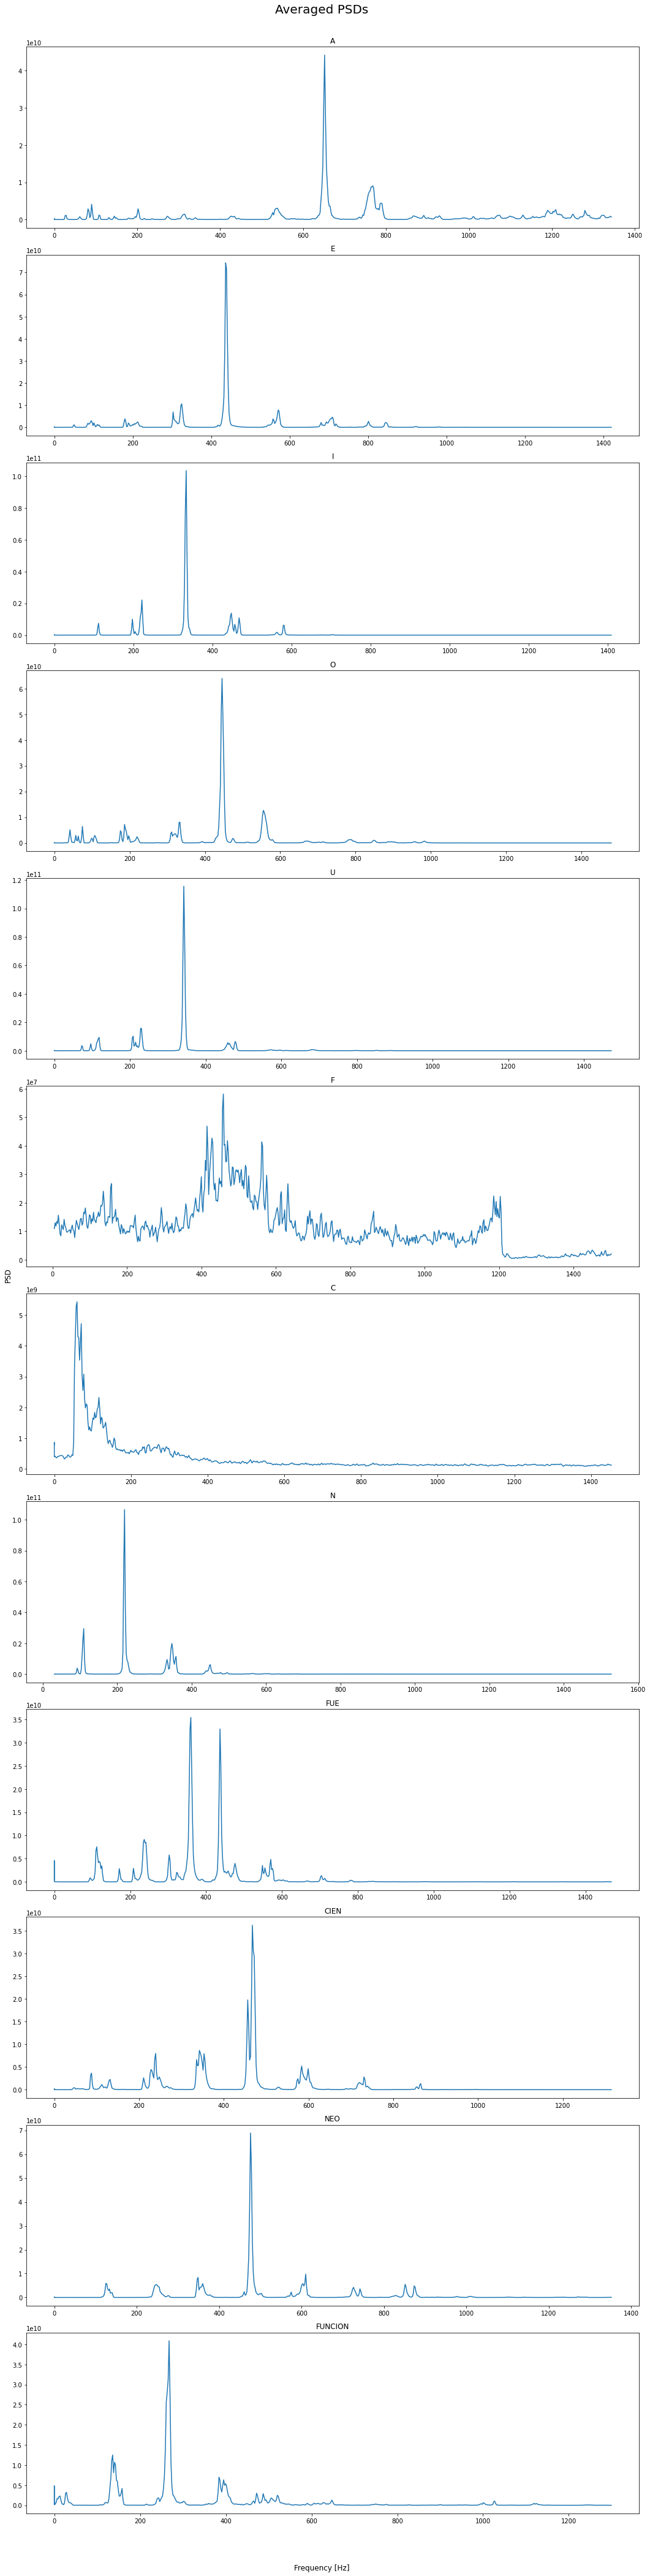

In [39]:
plot_spectral_density(averaged_psds, samples_titles=titles, fig_title="Averaged PSDs",
                      labels=None, max_freq_and_rate=max_freq_rate,
                      has_only_pos_freqs=True)

print(np.shape(averaged_psds))

## Potencia Total

In [40]:
arranged_psd = []
final_psd = []

for i in range(len(averaged_psds[0])):
    arranged_psd.append(get_positive_freqs_psd([averaged_psds[0][i][0], averaged_psds[0][i][1]]))

for j in range(len(arranged_psd)):
    sorted_indices = sorted(range(len(arranged_psd[j][0])), key=lambda i: arranged_psd[j][0][i])
    sorted_array1 = [arranged_psd[j][0][i] for i in sorted_indices]
    sorted_array2 = [arranged_psd[j][1][i] for i in sorted_indices]
    final_psd.append([sorted_array1, sorted_array2])

In [41]:
def area_psd(array, start=0, finish=None):
    suma = 0
    if finish is None:
        for j in range(start + 1, len(array[0]) - 1):
            prom = array[1][j]
            resta = (array[0][j + 1] - array[0][j - 1]) / 2
            suma += prom * resta
    else:
        for j in range(start + 1, finish - 1):
            prom = array[1][j]
            resta = (array[0][j + 1] - array[0][j - 1]) / 2
            suma += prom * resta
    return suma

La potencia total de A fue de 1206588890076.7625
La potencia total de E fue de 1228677521669.2913
La potencia total de I fue de 1207835433645.5442
La potencia total de O fue de 1270766621260.561
La potencia total de U fue de 1253301027314.5635
La potencia total de F fue de 1225119441611.35
La potencia total de C fue de 1198440517880.7058
La potencia total de N fue de 1243640499698.2239
La potencia total de FUE fue de 1211208661953.1743
La potencia total de CIEN fue de 1193729149484.8237
La potencia total de NEO fue de 1215683378072.4314
La potencia total de FUNCION fue de 1146196876986.9749
Sinedo la mayor de estas 1270766621260.561, que corresponde a la letra: O


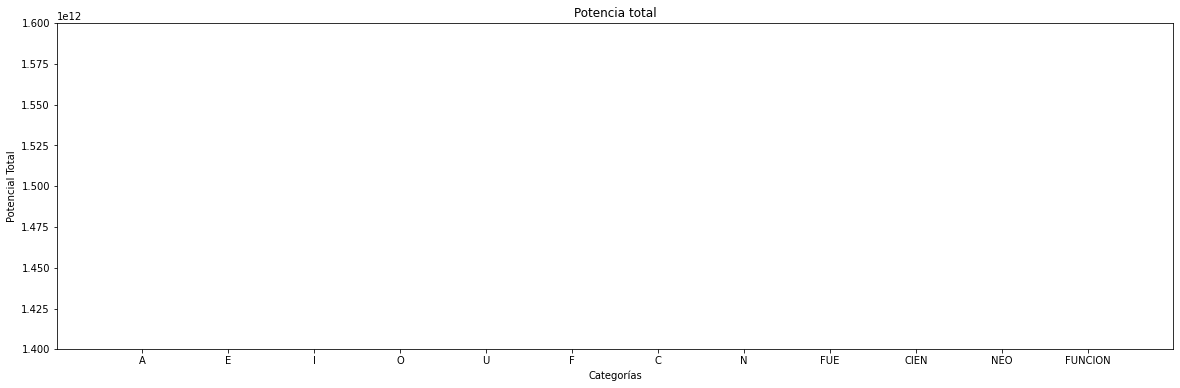

In [43]:
potencia_total = []

for i in range(len(final_psd)):
    potencia_total.append(area_psd(final_psd[i]))

max = np.max(potencia_total)

letra = 0
for i in range(len(potencia_total)):
    if potencia_total[i] != max:
        letra += 1
    else:
        break

r = ["A", "E", "I", "O", "U", "F", "C", "N", "FUE", "CIEN", "NEO", "FUNCION"]
for i in range(12):
    print(f"La potencia total de {r[i]} fue de {potencia_total[i]}")
print(f"Sinedo la mayor de estas {max}, que corresponde a la letra: " + r[letra])

# Crear el gráfico de barras con etiquetas en el eje x
plt.figure(figsize=(20, 6))
plt.bar(r, potencia_total)

# Personalizar el gráfico (opcional)
plt.xlabel('Categorías')
plt.ylabel('Potencial Total')
plt.title('Potencia total')
plt.ylim(1.4 * 10 ** 12, 1.6 * 10 ** 12)

# Mostrar el gráfico
plt.show()

## Potencia por Bandas de Frecuencia

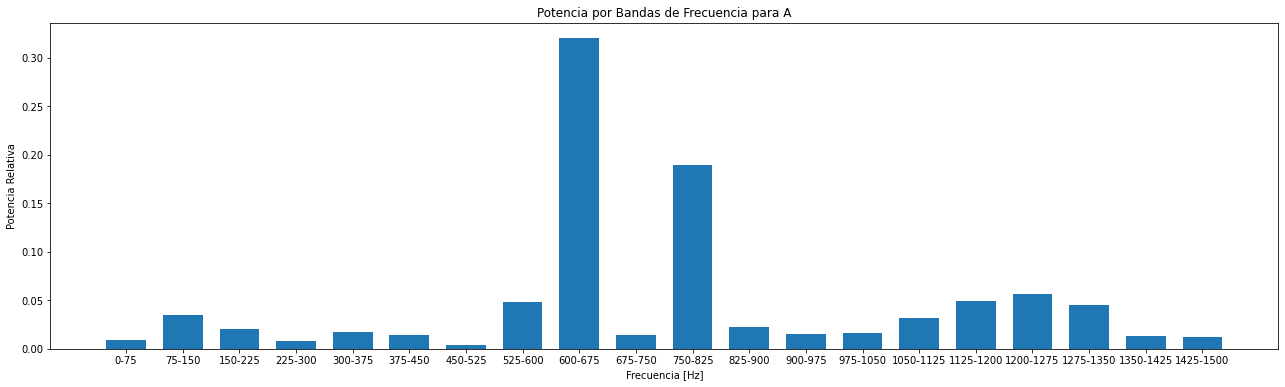

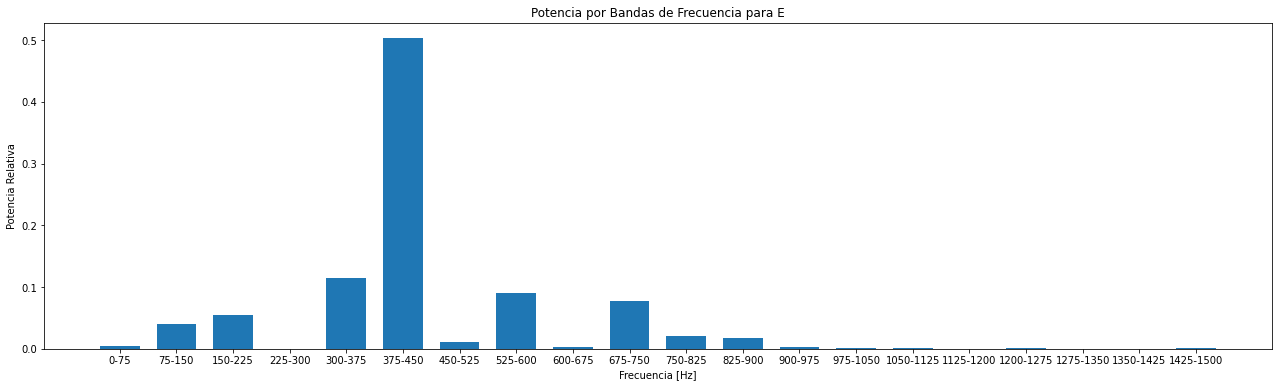

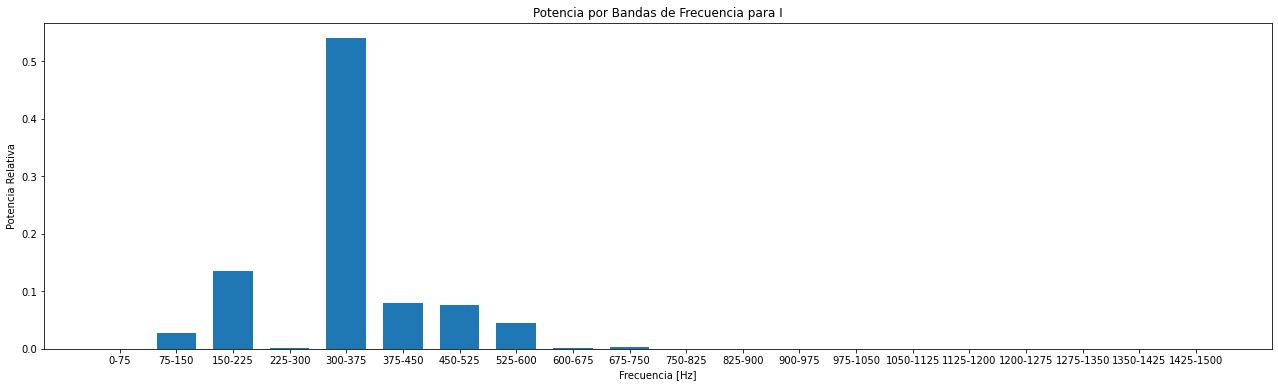

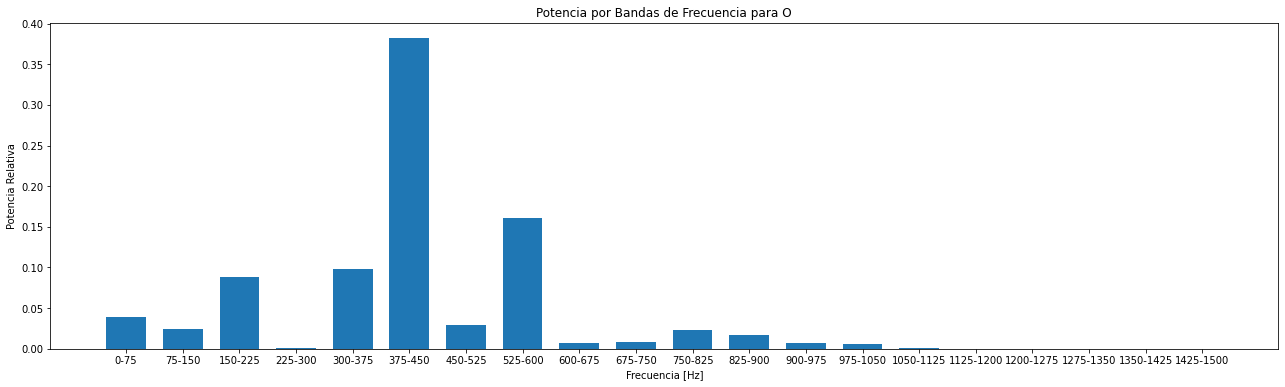

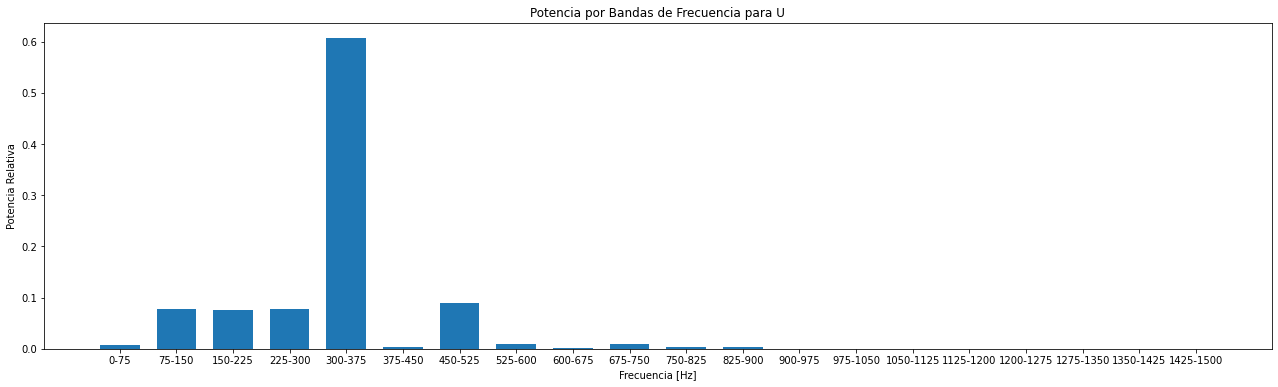

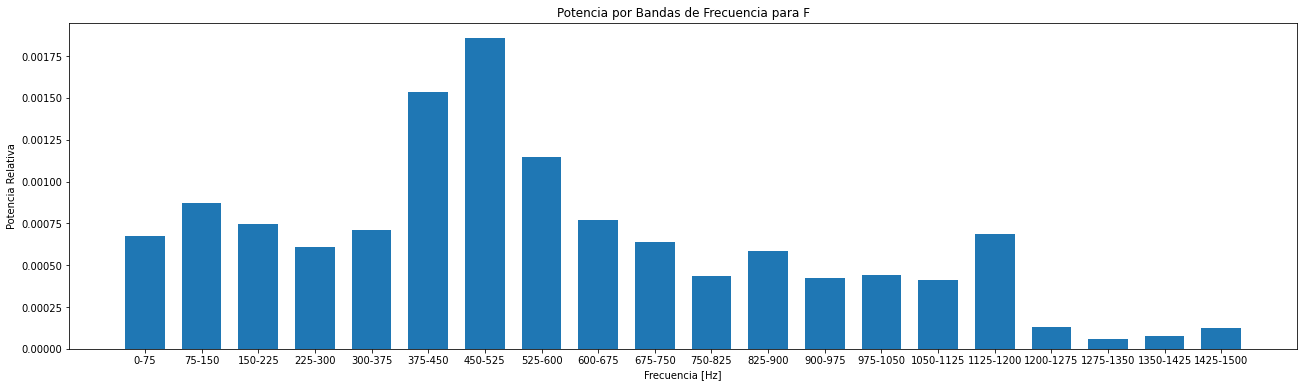

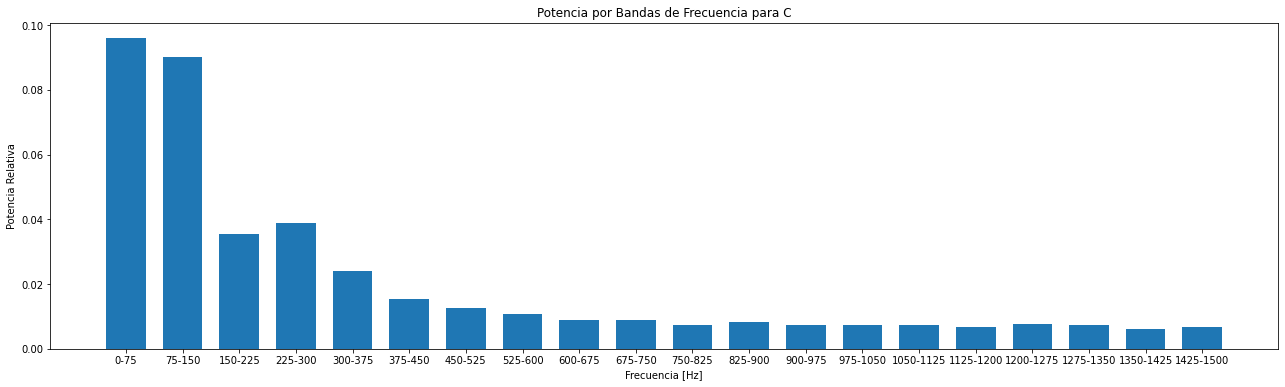

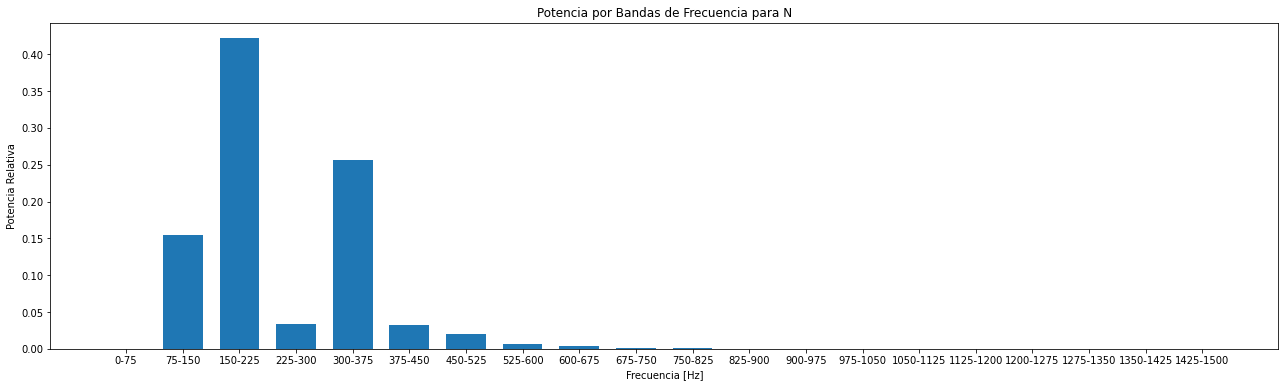

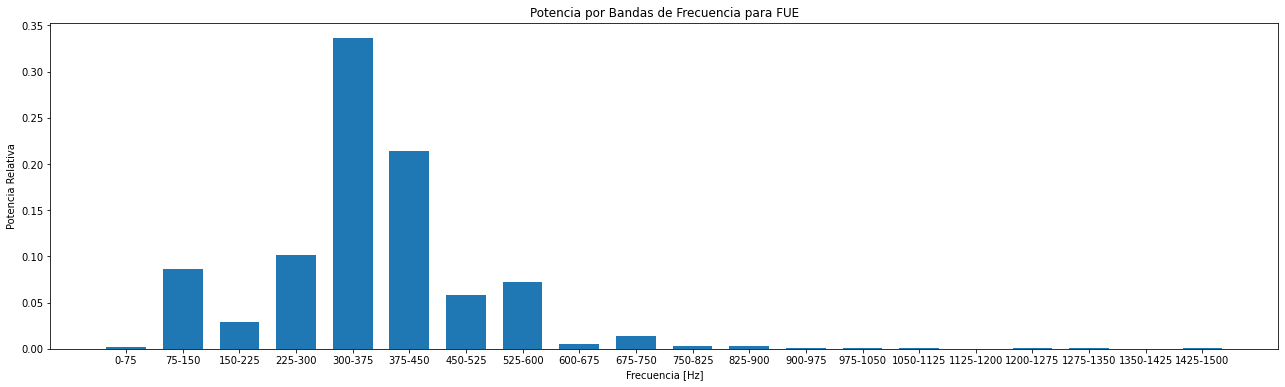

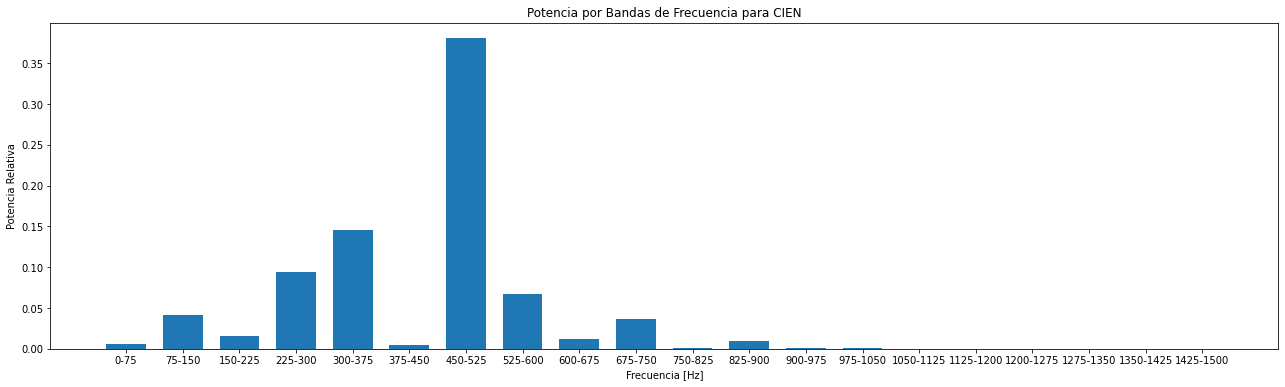

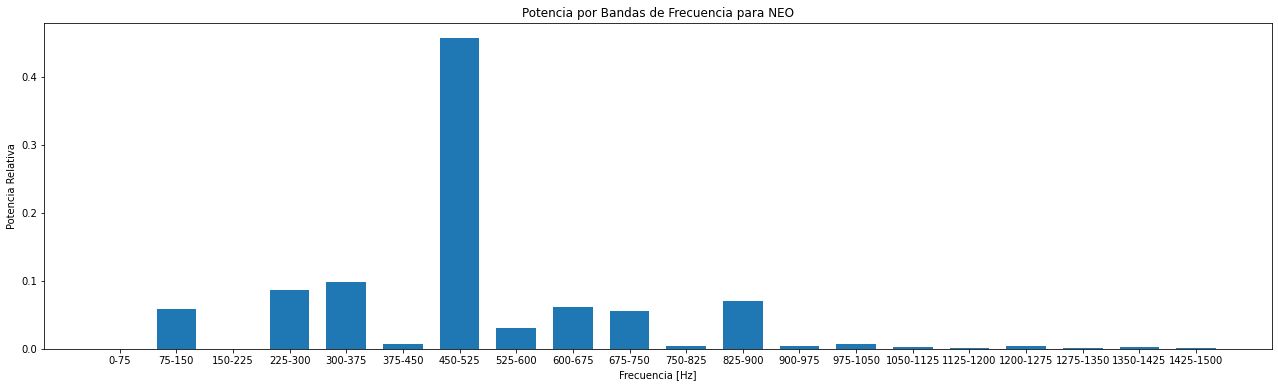

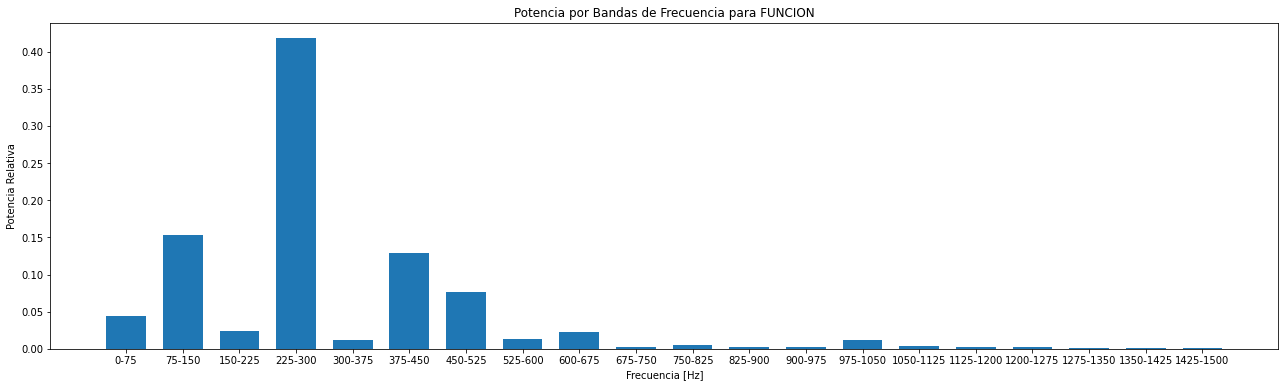

In [44]:
bandas = [0]
areas_bandas = []
xaxis_label = []
length = 75
num = int(1500 / length)

for i in range(num):
    bandas.append(bandas[i] + length)

for i in range(num):
    xaxis_label.append(f"{bandas[i]}-{bandas[i + 1]}")

indices = []
for i in range(12):
    subindices = [0]
    for k in range(1, len(bandas)):
        for j in range(1, len(final_psd[0][0]) - 1):
            if final_psd[i][0][j - 1] < bandas[k] and final_psd[i][0][j + 1] > bandas[k]:
                subindices.append(j + 1)
                break
    indices.append(subindices)

for i in range(len(indices)):
    sub_areas = []
    for j in range(len(indices[0]) - 1):
        sub_areas.append(area_psd(final_psd[i], indices[i][j], indices[i][j + 1]) / potencia_total[i])
    areas_bandas.append(sub_areas)

for i in range(12):
    plt.figure(figsize=(22, 6))
    plt.bar(xaxis_label, areas_bandas[i], width=0.7)
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Potencia Relativa')
    plt.title('Potencia por Bandas de Frecuencia para ' + r[i])
    plt.show()

## Referencias

[1] Baken, R. J. (2000). Clinical Measurement of Speech and Voice, 2nd Edition. London: Taylor and Francis Ltd. (pp. 177), ISBN 1-5659-3869-0. That in turn cites Fitch, J.L. and Holbrook, A. (1970). Modal Fundamental Frequency of Young Adults in Archives of Otolaryngology, 92, 379-382, Table 2 (p. 381).